# NEW STRUCTURE

**Important**: 
1. for each section, write about what you're gonna do and how. At the end a quick summary of the findings and next steps.
2. this md cell only serves as a guideline for our hackers. So this is not the final first md cell for the report.

---

## Table of Contents

---

### 0. Executive Summary
`🔲 TO BE WRITTEN LAST`

A concise summary (max 1 page) of the most important findings from the EDA. Written after all analyses are complete. Should cover:
- Dataset size, scope, and quality verdict
- 5–7 key findings that directly inform modeling decisions
- Identified risks and limitations
- Clear transition statement into feature engineering and modeling

---

### 1. Setup and Data Loading
`✅ DONE — minor cleanup needed`

- 1.1 Import libraries
- 1.2 Path configuration and environment setup
- 1.3 R2 download script (keep as optional cell, default OFF)
- 1.4 Load parquet partitions into DuckDB view

**Cleanup needed:** Remove sklearn/modeling imports from this section — they don't belong in EDA setup. Only import what's needed for EDA (duckdb, pandas, numpy, matplotlib, seaborn).

---

### 2. Dataset Overview and Quality Assessment
`✅ MOSTLY DONE — needs consolidation`

- 2.1 Shape, schema, and column types `✅`
- 2.2 Time coverage (years, date range) `✅`
- 2.3 Key categorical counts (regions, charts, unique tracks, unique artists) `✅`
- 2.4 Chart composition — Top 200 vs Viral 50 split `✅`
- 2.5 Global vs local row share `✅`

**Note:** Add a brief plain-English paragraph after this section: "What is this dataset? Each row represents..."  Already partially done — make sure it's prominent and clear.

---

### 3. Data Quality Assessment
`✅ MOSTLY DONE — consolidate and tighten`

- 3.1 Missing values — null rates per column `✅`
- 3.2 Missing value patterns — null-count-per-row distribution `✅`
- 3.3 Sample entries per null-count group (diagnostic table) `✅`
- 3.4 Streams: null and zero entry analysis `✅`
- 3.5 Row completeness summary `✅`
- 3.6 Duplicate check (track_id × region × date × chart) `✅`
- 3.7 Country coverage — active days, first/last seen per region `✅`
- 3.8 Data type issues — columns stored as VARCHAR that should be numeric `🔲`

**Action items:**
- Add section 3.8: explicitly list columns that need type casting (streams, rank, all af_* columns, popularity, duration_ms are all VARCHAR). Document the casting strategy.
- After section 3, write a **"Data Quality Verdict"** paragraph: what do we keep, what do we drop, what do we impute? This becomes the cleaning spec for the feature engineering pipeline.
- Specifically decide: do we drop rows where cultural_distance is null (~19%)? Do we drop rows where streams is null (~22%)? Document the decision and reasoning.

---

### 4. Filtering Decisions
`🔲 NEW SECTION NEEDED`

Before any analysis, document and execute the filtering decisions that define our working dataset:

- 4.1 Filter to Top 200 chart only (exclude Viral 50 from main analysis — Viral 50 used only as a feature flag)
- 4.2 Exclude "Global" region (it's an aggregation, not a country)
- 4.3 Handle countries without cultural distance data — drop or keep?
- 4.4 Deduplicate confirmed-identical duplicate rows
- 4.5 Define the clean working view (`spotify_clean`) with all filters applied
- 4.6 Print final working dataset shape and confirm

**Why this matters:** Every subsequent analysis must use the same clean base. Define it once here.

---

### 5. Univariate Analysis — Target Variable
`⚠️ PARTIALLY DONE — needs reframing around actual target`

This is the most important EDA section. It directly defines our prediction task.

- 5.1 Countries reached per song — distribution `✅ done in 8.3`
  - Histogram of number of countries per unique track
  - Key stats: median = 1, mean = 3, 73% never leave first country
- 5.2 Define the binary target threshold `🔲`
  - Test multiple thresholds (3, 5, 7, 10 countries)
  - Show class balance at each threshold
  - Pick threshold that gives ~25–35% positive rate
  - Justify the choice
- 5.3 Target variable by year `🔲`
  - Is cross-border success becoming more or less common over time?
- 5.4 Target variable by origin country `🔲`
  - Which origin countries produce the most internationally successful songs?
  - Is this just a function of market size?

---

### 6. Univariate Analysis — Features
`⚠️ PARTIALLY DONE — needs restructuring`

Analyze each feature group independently.

- 6.1 Audio features — distributions `✅ done in 8.4`
  - Histograms of all 9 audio features
  - Flag any that are heavily skewed or have outliers (instrumentalness is extremely right-skewed)
- 6.2 Streams distribution `✅ done in 7.5`
  - Linear and log-scale distributions
  - Percentile breakdown
- 6.3 Artist-level distributions `🔲`
  - Distribution of: tracks per artist, countries per artist, chart longevity per artist
  - Identify the "superstar" tail vs long tail of local artists
- 6.4 Release timing distributions `🔲`
  - Songs released by month/day of week
  - Any seasonal patterns?
- 6.5 Explicit content flag `🔲`
  - What proportion of songs are explicit?
  - Does this vary by country or genre?
- 6.6 Song language distribution `🔲`
  - If language has been inferred: what's the language breakdown?
  - What proportion of songs are English vs Spanish vs other?

---

### 7. Bivariate Analysis — Features vs Target
`🔲 NEW SECTION — CRITICAL`

This is where we test whether our planned features actually relate to cross-border success. Every planned model feature should appear here.

- 7.1 Audio features vs target `🔲`
  - Compare audio feature distributions for songs that traveled (5+ countries) vs songs that didn't
  - Box plots or violin plots split by target class
  - **Hypothesis:** Based on correlation analysis (all < 0.02 with streams), audio features alone likely won't be strong predictors. Confirm or refute this.
- 7.2 Artist profile vs target `🔲`
  - Do songs by artists with more prior international hits travel further?
  - Scatter: artist_prior_unique_regions vs countries_reached for current song
  - This should show the strongest signal in the dataset
- 7.3 Origin country vs target `🔲`
  - Bar chart: proportion of songs that become international hits, by origin country
  - Are US/UK origin songs more likely to travel?
- 7.4 Explicit flag vs target `🔲`
  - Does explicit content help or hurt international spread?
- 7.5 Release timing vs target `🔲`
  - Do songs released in certain months travel more?
- 7.6 Viral 50 flag vs target `🔲`
  - Are songs that appear on Viral 50 more likely to chart internationally?
  - This tests whether organic buzz predicts cross-border success

---

### 8. Geographic and Cultural Analysis
`⚠️ PARTIALLY DONE — needs significant expansion`

This is the most novel part of our EDA and directly supports our core hypothesis.

- 8.1 Country-level stream volume comparison `✅ done in 8.1`
  - Average/median streams by country
  - Market size ranking
- 8.2 Continent-level stream comparison `✅ done`
  - Box plots of log(streams) by continent
- 8.3 Cross-border flow matrix `🔲 CRITICAL`
  - For all songs that charted in 2+ countries: build a country × country co-occurrence matrix
  - Heatmap: "if a song charts in country A, how likely is it to also chart in country B?"
  - This directly validates the geographic relationship features
- 8.4 Language analysis `🔲 CRITICAL`
  - Do songs travel more to countries that share their language?
  - Compare: Spanish songs → spread to Latin American countries vs non-Spanish-speaking countries
  - English songs → spread pattern vs non-English songs
  - This validates the `same_language_flag` feature
- 8.5 Cultural distance analysis `🔲 CRITICAL`
  - Plot: cultural_distance vs probability of cross-border charting
  - Does lower cultural distance = higher probability of song traveling?
  - This validates the `cultural_distance_origin_target` feature
- 8.6 Diffusion timeline analysis `🔲`
  - For songs that traveled: how long does it take to reach the 2nd, 3rd, 5th, 10th country?
  - Median/distribution of days_to_arrive by country
  - Are some countries consistently "early adopters" and others "late followers"?
- 8.7 Chart stay analysis `✅ done in 8.1`
  - Longest/shortest chart stays
  - Distribution of chart duration per song per country

---

### 9. Correlation and Multicollinearity
`⚠️ DONE but needs expansion`

- 9.1 Correlation matrix — audio features `✅ done in 8.5`
  - Heatmap with values
  - Flag highly correlated pairs (energy–loudness)
- 9.2 Correlation with target variable `🔲`
  - Correlate all numeric features with the binary target (international success yes/no)
  - This replaces the current correlation with log(streams) which is irrelevant to our task
- 9.3 Multicollinearity check `🔲`
  - VIF (Variance Inflation Factor) for planned numeric features
  - Identify features that might need to be dropped or combined

---

### 10. Key Findings Summary
`🔲 TO BE WRITTEN AFTER ALL ANALYSES`

Structured summary of findings organized by decision they inform:

- 10.1 Target variable decision — chosen threshold and justification
- 10.2 Feature relevance ranking — which features show strongest signal?
- 10.3 Data quality decisions — what was dropped/imputed and why
- 10.4 Geographic/cultural hypotheses — confirmed or refuted?
- 10.5 Risks and limitations for modeling
- 10.6 Transition to feature engineering — explicit list of features to build

---

### ~~11–16. Modeling sections~~
`❌ REMOVED — modeling belongs in a separate notebook`

All modeling (linear regression, regularization, gradient descent) has been moved out of this EDA notebook. Modeling will be done in `04_modeling.ipynb` after feature engineering is complete. The EDA notebook's job is to understand the data, not to fit models.

---

## Formatting Standards

To ensure consistency and address professor feedback from 2022:

- **Figure sizes:** Standardize to `figsize=(12, 6)` for wide plots, `figsize=(8, 6)` for square plots. Never exceed `figsize=(14, 8)`.
- **Titles and labels:** Every plot must have a title, axis labels, and readable font sizes (min 11pt).
- **Colors:** Use a consistent palette throughout. Avoid red-green combinations (accessibility). Suggested: `steelblue` for primary, `salmon` for secondary, `seaborn` default palette for multi-category.
- **Markdown cells:** Every code section must be preceded by a markdown cell explaining (1) what we're doing, (2) why, and (3) what to look for in the output.
- **Insight cells:** After every analysis, include a markdown cell with **"Key takeaway:"** stating the finding in plain English and its implication for modeling.
- **No raw code output without interpretation.** If a table or number is displayed, explain what it means.

# Team EDA Baseline (Full Data + R2 Download)

This notebook is the teammate-ready baseline for EDA on the full V1 merged dataset (no additional cleaning/feature engineering in this notebook).

Scope:
- Validate `scripts/r2.env` configuration
- Optionally run `scripts/download_from_r2.sh` to fetch `datasets/<DATASET_VERSION>/`
- Load full parquet partitions as a DuckDB view (`spotify_full`). Pandas is not possible because Dataset is too big for a full EDA.
- Run starter SQL EDA queries (shape, null rates, top regions/charts, yearly streams, audio feature summary)

## 1) Executive Summary

After we are done here: 

## 2) Load Project Dependencies and Paths

In [1]:
from pathlib import Path
import os
import re
import json
import textwrap
import subprocess
from typing import Dict, List, Tuple
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



In [2]:

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name != "Project_Information":
    for candidate in [Path.cwd(), *Path.cwd().parents]:
        if (candidate / "scripts").exists() and (candidate / "datasets").exists():
            NOTEBOOK_DIR = candidate / "Project_Information" if (candidate / "Project_Information").exists() else candidate
            break

REPO_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "Project_Information" else NOTEBOOK_DIR
SCRIPTS_DIR = REPO_ROOT / "scripts"
DEFAULT_DATASET_VERSION = "v1"
DEFAULT_DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DEFAULT_DATASET_VERSION
R2_ENV_PATH = SCRIPTS_DIR / "r2.env"
R2_ENV_EXAMPLE_PATH = SCRIPTS_DIR / "r2.env.example"
OUTPUT_DIR = NOTEBOOK_DIR / "outputs" / "team_eda_baseline"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Scripts dir: {SCRIPTS_DIR}")
print(f"Default download root: {DEFAULT_DOWNLOAD_ROOT}")
print(f"R2 env file: {R2_ENV_PATH}")
print(f"Output dir: {OUTPUT_DIR}")

Repo root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB
Scripts dir: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/scripts
Default download root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
R2 env file: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/scripts/r2.env
Output dir: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/Project_Information/outputs/team_eda_baseline


## 3) Parse and Validate `scripts/r2.env` Configuration

In [3]:
REQUIRED_R2_KEYS = [
    "R2_ENDPOINT",
    "R2_BUCKET",
    "AWS_ACCESS_KEY_ID",
    "AWS_SECRET_ACCESS_KEY",
    "DATASET_VERSION",
]


def _strip_balanced_quotes(value: str) -> str:
    if len(value) >= 2 and ((value[0] == '"' and value[-1] == '"') or (value[0] == "'" and value[-1] == "'")):
        return value[1:-1]
    return value


def parse_env_file(env_path: Path) -> Tuple[Dict[str, str], List[str]]:
    parsed: Dict[str, str] = {}
    errors: List[str] = []

    if not env_path.exists():
        errors.append(f"Missing env file: {env_path}")
        return parsed, errors

    for line_no, raw_line in enumerate(env_path.read_text(encoding="utf-8").splitlines(), start=1):
        line = raw_line.strip()
        if not line or line.startswith("#"):
            continue
        if "=" not in line:
            errors.append(f"Line {line_no}: missing '=' separator")
            continue

        key, value = line.split("=", 1)
        key = key.strip()
        value = value.strip()

        if not re.fullmatch(r"[A-Za-z_][A-Za-z0-9_]*", key):
            errors.append(f"Line {line_no}: invalid key '{key}'")
            continue

        dbl_quote_count = value.count('"')
        sgl_quote_count = value.count("'")
        if dbl_quote_count % 2 != 0 or sgl_quote_count % 2 != 0:
            errors.append(
                f"Line {line_no}: malformed quotes for key '{key}' -> {value!r}"
            )
            continue

        normalized = _strip_balanced_quotes(value).strip()

        if normalized.endswith('"') or normalized.endswith("'"):
            errors.append(
                f"Line {line_no}: value for '{key}' appears to have a trailing quote -> {value!r}"
            )

        parsed[key] = normalized

    missing = [k for k in REQUIRED_R2_KEYS if not parsed.get(k)]
    if missing:
        errors.append(f"Missing required keys: {missing}")

    return parsed, errors


r2_config, r2_config_errors = parse_env_file(R2_ENV_PATH)

if r2_config_errors:
    print("r2.env validation failed:")
    for err in r2_config_errors:
        print(f"  - {err}")
    if R2_ENV_EXAMPLE_PATH.exists():
        print(f"\nTemplate available at: {R2_ENV_EXAMPLE_PATH}")
else:
    print("r2.env validation passed")
    display(pd.DataFrame([r2_config]).T.rename(columns={0: "value"}))

r2.env validation passed


,value
R2_ENDPOINT,https://a96b93c5d97cddb48fc674255fb687c7.r2.cl...
R2_BUCKET,ml-group-ab-datasets
AWS_ACCESS_KEY_ID,b4f318900453ff77a06d530e454aa330
AWS_SECRET_ACCESS_KEY,e196e275699090f32d71db4854983855b8b3fc05905a80...
DATASET_VERSION,v1


## 4) Implement Safe Environment Variable Export for Shell Commands

In [4]:
def build_sanitized_env(base_env: Dict[str, str], overrides: Dict[str, str] | None = None) -> Dict[str, str]:
    if r2_config_errors:
        raise ValueError("Cannot build environment: r2.env is invalid.")

    env = dict(os.environ)
    for key in REQUIRED_R2_KEYS:
        env[key] = str(base_env[key]).strip()

    if overrides:
        for k, v in overrides.items():
            if v is not None:
                env[k] = str(v)

    return env


def run_bash_script(script_path: Path, env: Dict[str, str], cwd: Path, timeout: int = 3600) -> subprocess.CompletedProcess:
    if not script_path.exists():
        raise FileNotFoundError(f"Missing script: {script_path}")

    cmd = ["bash", str(script_path)]
    result = subprocess.run(
        cmd,
        cwd=str(cwd),
        env=env,
        capture_output=True,
        text=True,
        timeout=timeout,
    )

    print("--- stdout ---")
    print(result.stdout[-4000:] if result.stdout else "<empty>")
    print("--- stderr ---")
    print(result.stderr[-4000:] if result.stderr else "<empty>")
    print(f"Exit code: {result.returncode}")

    if result.returncode != 0:
        raise RuntimeError(
            "Download script failed. Check stdout/stderr above. "
            "For permission-related preflight errors, try SKIP_R2_PREFLIGHT=1."
        )

    return result

print("Shell helper ready")

Shell helper ready


## 5) Run Dataset Download Script

This cell is safe by default (`RUN_DOWNLOAD = False`). Set it to `True` when ready.

In [5]:
DOWNLOAD_SCRIPT = SCRIPTS_DIR / "download_from_r2.sh"
DATASET_VERSION = r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION) if not r2_config_errors else DEFAULT_DATASET_VERSION
DOWNLOAD_ROOT = REPO_ROOT / "datasets" / DATASET_VERSION

RUN_DOWNLOAD = False  # modify to False to skip actual download

print(f"Default DATASET_VERSION: {DATASET_VERSION}")
print(f"Default DOWNLOAD_ROOT: {DOWNLOAD_ROOT}")

if RUN_DOWNLOAD:
    env_default = build_sanitized_env(
        r2_config,
        overrides={
            "DATASET_VERSION": DATASET_VERSION,
            "DOWNLOAD_ROOT": str(DOWNLOAD_ROOT),
        },
    )
    run_bash_script(DOWNLOAD_SCRIPT, env=env_default, cwd=REPO_ROOT)
else:
    print("Skipped default run. Set RUN_DOWNLOAD=True to execute.")

Default DATASET_VERSION: v1
Default DOWNLOAD_ROOT: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
Skipped default run. Set RUN_DOWNLOAD=True to execute.


## 6) Load Parquet as DuckDB View (No Full In-Memory DataFrame)

In [6]:
if "DOWNLOAD_ROOT" not in globals():
    fallback_version = (
        r2_config.get("DATASET_VERSION", DEFAULT_DATASET_VERSION)
        if "r2_config" in globals() and "DEFAULT_DATASET_VERSION" in globals()
        else "v1"
    )
    DOWNLOAD_ROOT = REPO_ROOT / "datasets" / fallback_version

active_download_root = DOWNLOAD_ROOT
full_root = active_download_root / "full"
if not full_root.exists():
    raise FileNotFoundError(f"Full dataset folder not found: {full_root}")

parquet_files = sorted(full_root.rglob("*.parquet"))
if not parquet_files:
    raise FileNotFoundError(f"No parquet files found under: {full_root}")

print(f"Active download root: {active_download_root}")
print(f"Total parquet files in full dataset: {len(parquet_files)}")

try:
    import duckdb
except ImportError as exc:
    raise ImportError(
        "duckdb is required for SQL-based EDA. Install it with: pip install duckdb"
    ) from exc

con = duckdb.connect(database=":memory:")
parquet_glob = (full_root / "year=*" / "*.parquet").as_posix()

con.execute(
    f"""
    CREATE OR REPLACE VIEW spotify_full AS
    SELECT *
    FROM read_parquet('{parquet_glob}', hive_partitioning = true);
    """
)


Active download root: /Users/henrikpeuker/Documents/GitHub/ML_Group_AB/datasets/v1
Total parquet files in full dataset: 24


# Exploratory Data Analyis

## 7. Dataset Overview and Quality Assessment

### 7.1 Variable Types

In [7]:
print("=" * 65)
print("  DATASET OVERVIEW — spotify_full")
print("=" * 65)

# 1. Total rows & columns 
row_count = con.execute("SELECT COUNT(*) FROM spotify_full").fetchone()[0]
schema_df = con.execute("DESCRIBE spotify_full").df()
print(f"\n  Rows   : {row_count:>12,}")
print(f"  Columns: {len(schema_df):>12}")

# 2. Schema — column name + data type 
print("\n── Columns ────────────────────────────────────────────────────")
print(f"  {'#':<4} {'Column':<35} {'Type'}")
print(f"  {'-'*4} {'-'*35} {'-'*15}")
for i, row in schema_df.iterrows():
    print(f"  {i+1:<4} {row['column_name']:<35} {row['column_type']}")

# 3. Date / time coverage
date_range = con.execute("""
    SELECT
        MIN(year)  AS year_min,
        MAX(year)  AS year_max,
        COUNT(DISTINCT year) AS n_years
    FROM spotify_full
""").df()
print("\n── Time Coverage ──────────────────────────────────────────────")
print(f"  Years covered : {int(date_range['year_min'][0])} – {int(date_range['year_max'][0])}")
print(f"  Distinct years: {int(date_range['n_years'][0])}")

# 4. Key categorical counts
counts = con.execute("""
    SELECT
        COUNT(DISTINCT region)           AS n_regions,
        COUNT(DISTINCT chart)            AS n_chart_types,
        COUNT(DISTINCT track_id)         AS n_unique_tracks,
        COUNT(DISTINCT artist)           AS n_unique_artists
    FROM spotify_full
""").df()

print("\n── Key Counts ─────────────────────────────────────────────────")
for col in counts.columns:
    print(f"  {col:<30}: {int(counts[col][0]):>10,}")

# 5. Sample rows 
print("\n── Sample Rows (5) ────────────────────────────────────────────")
sample = con.execute("""
    SELECT date, region, chart, rank,
           track_id, artist,
           TRY_CAST(streams AS BIGINT) AS streams,
           year
    FROM spotify_full
    LIMIT 5
""").df()
display(sample)

# 6. Plain-English description 
description = """
What is this dataset?
  Each row represents one song's chart entry for a given date, chart type,
  and country/region. It captures the Spotify Top 200 (and Viral 50) charts
  globally, recorded daily.

Key columns at a glance:
  date / year       – when the chart entry was recorded
  region            – country or 'global' the chart belongs to
  chart             – chart type, 'top200' or 'viral50'
  rank              – position on that chart (1 = #1 song)
  track_name        – song title
  artist            – performing artist(s)
  streams           – number of streams on that day for that song/region
  track_id          – Spotify track URI (unique per song)
  af_*              – Spotify Audio Features (danceability, energy, valence,
                      tempo, loudness, acousticness, speechiness,
                      instrumentalness, liveness)
  popularity        – Spotify popularity score (0–100) at time of entry
  explicit          – whether the track contains explicit content
  country_continent – continent derived from region (engineered feature)
"""
print(textwrap.dedent(description))
print("=" * 65)

  DATASET OVERVIEW — spotify_full

  Rows   :   26,174,269
  Columns:           46

── Columns ────────────────────────────────────────────────────
  #    Column                              Type
  ---- ----------------------------------- ---------------
  1    title                               VARCHAR
  2    rank                                VARCHAR
  3    date                                VARCHAR
  4    artist                              VARCHAR
  5    url                                 VARCHAR
  6    region                              VARCHAR
  7    chart                               VARCHAR
  8    trend                               VARCHAR
  9    streams                             VARCHAR
  10   track_id                            VARCHAR
  11   album                               VARCHAR
  12   popularity                          VARCHAR
  13   duration_ms                         VARCHAR
  14   explicit                            VARCHAR
  15   release_date            

,date,region,chart,rank,track_id,artist,streams,year
0,2017-01-01,Argentina,top200,1,6mICuAdrwEjh6Y6lroV2Kg,Shakira,253019,2017
1,2017-01-01,Argentina,top200,2,7DM4BPaS7uofFul3ywMe46,Ricky Martin,223988,2017
2,2017-01-01,Argentina,top200,3,3AEZUABDXNtecAOSC1qTfo,CNCO,210943,2017
3,2017-01-01,Argentina,top200,4,6rQSrBHf7HlZjtcMZ4S4bO,"J Balvin, Pharrell Williams, BIA, Sky",173865,2017
4,2017-01-01,Argentina,top200,5,58IL315gMSTD37DOZPJ2hf,Daddy Yankee,153956,2017



What is this dataset?
  Each row represents one song's chart entry for a given date, chart type,
  and country/region. It captures the Spotify Top 200 (and Viral 50) charts
  globally, recorded daily.

Key columns at a glance:
  date / year       – when the chart entry was recorded
  region            – country or 'global' the chart belongs to
  chart             – chart type, 'top200' or 'viral50'
  rank              – position on that chart (1 = #1 song)
  track_name        – song title
  artist            – performing artist(s)
  streams           – number of streams on that day for that song/region
  track_id          – Spotify track URI (unique per song)
  af_*              – Spotify Audio Features (danceability, energy, valence,
                      tempo, loudness, acousticness, speechiness,
                      instrumentalness, liveness)
  popularity        – Spotify popularity score (0–100) at time of entry
  explicit          – whether the track contains explicit content


In [44]:
print("\n── Sample Rows (5) ────────────────────────────────────────────")
sample = con.execute("""
    SELECT *
    FROM spotify_full
    LIMIT 5
""").df()
display(sample)


── Sample Rows (5) ────────────────────────────────────────────


,title,rank,date,artist,url,region,chart,trend,streams,track_id,...,country_major_religions,country_govt_type,country_driving_side,cultural_distance_mean,cultural_distance_median,cultural_distance_min,cultural_distance_max,cultural_distance_count,cultural_top5_targets,index
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0,6mICuAdrwEjh6Y6lroV2Kg,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0,7DM4BPaS7uofFul3ywMe46,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0,3AEZUABDXNtecAOSC1qTfo,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0,58IL315gMSTD37DOZPJ2hf,...,Christianity,Republic,right,1.279542,1.1075,0.154,4.031,118,Malta|Greece|Italy|Luxembourg|Czech republic,3.0


,chart,row_count,pct_rows
0,top200,20321961,77.64
1,viral50,5852308,22.36


Global vs local row share:


,scope,row_count,pct_rows
0,local,25722465,98.27
1,global,451804,1.73


Chart mix by year (row counts):


chart,top200,viral50
year,,
2017,3386564,1015273
2018,3739327,1123728
2019,4210217,1202469
2020,4550811,1242344
2021,4435042,1268494


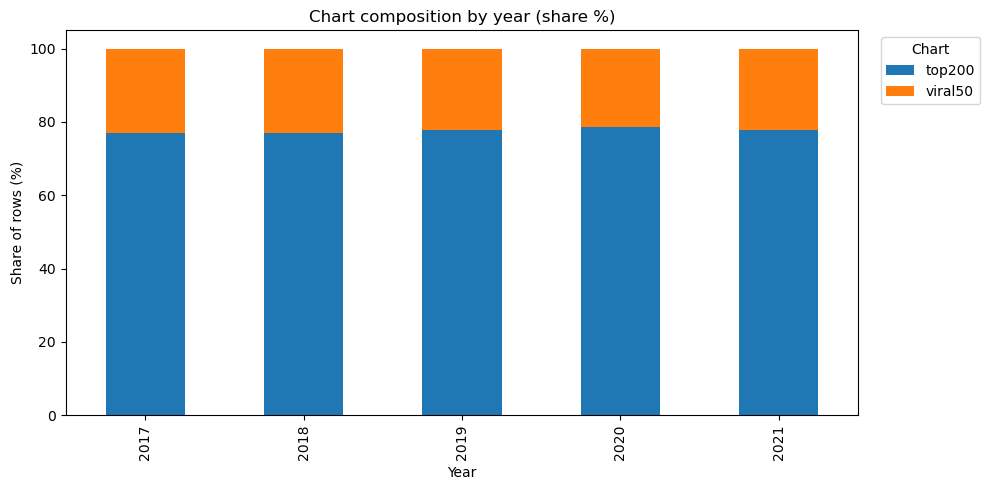

In [8]:
# 3.3 Chart composition
chart_mix_df = con.execute("""
SELECT
    chart,
    COUNT(*) AS row_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct_rows
FROM spotify_full
GROUP BY chart
ORDER BY row_count DESC;
""").df()

display(chart_mix_df)

global_share_df = con.execute("""
SELECT
    CASE WHEN LOWER(region) = 'global' THEN 'global' ELSE 'local' END AS scope,
    COUNT(*) AS row_count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER (), 2) AS pct_rows
FROM spotify_full
GROUP BY 1
ORDER BY row_count DESC;
""").df()

print("Global vs local row share:")
display(global_share_df)

chart_mix_by_year_df = con.execute("""
WITH y AS (
    SELECT
        CASE
            WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN TRY_CAST(year AS INTEGER)
            ELSE EXTRACT(YEAR FROM TRY_CAST(date AS DATE))::INTEGER
        END AS year_val,
        chart
    FROM spotify_full
)
SELECT
    year_val AS year,
    chart,
    COUNT(*) AS row_count
FROM y
WHERE year_val IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2;
""").df()

chart_mix_year_pivot = chart_mix_by_year_df.pivot(index="year", columns="chart", values="row_count").fillna(0).sort_index()
chart_mix_year_share = chart_mix_year_pivot.div(chart_mix_year_pivot.sum(axis=1), axis=0) * 100

print("Chart mix by year (row counts):")
display(chart_mix_year_pivot.astype(int))

ax = chart_mix_year_share.plot(kind="bar", stacked=True, figsize=(10, 5))
ax.set_title("Chart composition by year (share %)")
ax.set_xlabel("Year")
ax.set_ylabel("Share of rows (%)")
plt.legend(title="Chart", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 7.2 Missing values


In [9]:
null_rows = []
for col in schema_df["column_name"].tolist():
    # Quote identifiers safely for DuckDB
    col_quoted = f'"{col}"'
    q = f"""SELECT '{col}' AS column_name,
                    AVG(CASE WHEN {col_quoted} IS NULL THEN 1.0 ELSE 0.0 END) AS null_rate
             FROM spotify_full"""
    null_rows.append(con.execute(q).df())

null_df = pd.concat(null_rows, ignore_index=True).sort_values("null_rate", ascending=False)
print("\nMissingness (top 15 by null rate):")
display(null_df.head(15))


Missingness (top 15 by null rate):


,column_name,null_rate
8,streams,0.223590
45,index,0.193528
44,cultural_top5_targets,0.193528
43,cultural_distance_count,0.193528
42,cultural_distance_max,0.193528
41,cultural_distance_min,0.193528
40,cultural_distance_median,0.193528
39,cultural_distance_mean,0.193528
33,country_population,0.034378
38,country_driving_side,0.034378


In [10]:
# ── Count entries with 0 or NULL streams ─────────────────────────────────────
stream_quality = con.execute("""
    SELECT
        COUNT(*)                                                          AS total_rows,
        SUM(CASE WHEN streams IS NULL THEN 1 ELSE 0 END)                 AS null_streams,
        SUM(CASE WHEN streams IS NULL
                  OR TRY_CAST(streams AS DOUBLE) = 0 THEN 1 ELSE 0 END)  AS null_or_zero_streams
    FROM spotify_full

""").df()

total = stream_quality["total_rows"][0]
null_s  = stream_quality["null_streams"][0]
valid_s = total-null_s

print("═" * 50)
print("  STREAMS — NULL / ZERO ENTRY COUNT")
print("═" * 50)
print(f"  Total rows          : {total:>12,} ({total/total*100:.2f}%)")
print(f"  NULL streams        : {null_s:>12,}  ({null_s/total*100:.2f}%)")
print(f"Total valid stream    : {valid_s:> 12,} ({valid_s/total*100:.2f}%)")

print("═" * 50)


══════════════════════════════════════════════════
  STREAMS — NULL / ZERO ENTRY COUNT
══════════════════════════════════════════════════
  Total rows          :   26,174,269 (100.00%)
  NULL streams        :  5,852,308.0  (22.36%)
Total valid stream    :  20,321,961.0 (77.64%)
══════════════════════════════════════════════════


In [11]:
# ── Count entries with zero missing values (complete rows) ───────────────────
schema_df = con.execute("DESCRIBE spotify_full").df()
all_cols  = schema_df["column_name"].tolist()

# Build a CASE expression that counts NULLs across all columns per row
null_count_expr = " + ".join(
    [f"CASE WHEN \"{c}\" IS NULL THEN 1 ELSE 0 END" for c in all_cols]
)

completeness = con.execute(f"""
    SELECT
        COUNT(*)                                                      AS total_rows,
        SUM(CASE WHEN ({null_count_expr}) = 0 THEN 1 ELSE 0 END)     AS complete_rows,
        SUM(CASE WHEN ({null_count_expr}) > 0 THEN 1 ELSE 0 END)     AS rows_with_any_null,
        AVG(CASE WHEN ({null_count_expr}) = 0 THEN 1.0 ELSE 0.0 END) AS complete_rate
    FROM spotify_full
""").df()

total    = int(completeness["total_rows"][0])
complete = int(completeness["complete_rows"][0])
any_null = int(completeness["rows_with_any_null"][0])
rate     = float(completeness["complete_rate"][0])

print("═" * 55)
print("  ROW COMPLETENESS — zero missing values")
print("═" * 55)
print(f"  Total rows              : {total:>12,}")
print(f"  Complete rows (0 nulls) : {complete:>12,}  ({rate*100:.2f}%)")
print(f"  Rows with ≥1 null       : {any_null:>12,}  ({(1-rate)*100:.2f}%)")
print("═" * 55)

# ── Breakdown: how many nulls per row (distribution) ─────────────────────────
print("\n── Distribution of null-count-per-row ────────────────────────")
null_dist = con.execute(f"""
    SELECT
        ({null_count_expr}) AS n_nulls_in_row,
        COUNT(*)             AS n_rows
    FROM spotify_full
    GROUP BY n_nulls_in_row
    ORDER BY n_nulls_in_row
""").df()
display(null_dist)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

═══════════════════════════════════════════════════════
  ROW COMPLETENESS — zero missing values
═══════════════════════════════════════════════════════
  Total rows              :   26,174,269
  Complete rows (0 nulls) :   16,423,650  (62.75%)
  Rows with ≥1 null       :    9,750,619  (37.25%)
═══════════════════════════════════════════════════════

── Distribution of null-count-per-row ────────────────────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_nulls_in_row,n_rows
0,0,16423650
1,1,4428366
2,2,2601
3,3,4
4,7,3159976
5,8,962274
6,9,554
7,14,719359
8,15,173128
9,16,106


Integrated country diagnostics (top 25 by missing days):


,region,first_seen,last_seen,chart_rows,active_days,expected_days,missing_days,missing_days_pct,avg_streams,median_streams,total_streams
69,South Korea,2021-02-01,2021-12-31,76276,334,1826,1492,81.71,2687.430431,1826.0,1.600042e+08
66,Russia,2020-07-14,2021-12-31,126837,536,1826,1290,70.65,21099.099929,16537.5,2.124933e+09
65,Ukraine,2020-07-14,2021-12-31,127544,536,1826,1290,70.65,4333.549126,3432.0,4.366094e+08
55,India,2019-02-26,2021-12-31,253036,1040,1826,786,43.04,47457.710627,39744.0,9.554756e+09
58,Saudi Arabia,2018-11-19,2021-12-31,231649,1136,1826,690,37.79,3254.551647,2419.0,5.693740e+08
62,Morocco,2018-11-19,2021-12-31,191537,1136,1826,690,37.79,3088.643339,2133.0,4.164541e+08
64,Egypt,2018-11-19,2021-12-31,180469,1136,1826,690,37.79,2551.200398,1936.0,3.157468e+08
60,United Arab Emirates,2018-11-15,2021-12-31,198944,1140,1826,686,37.57,2147.140823,1649.0,3.050035e+08
52,Vietnam,2018-03-14,2021-12-31,312426,1389,1826,437,23.93,5695.451309,4076.0,1.387566e+09
50,Israel,2018-03-14,2021-12-31,330046,1389,1826,437,23.93,4703.704607,3805.0,1.230541e+09


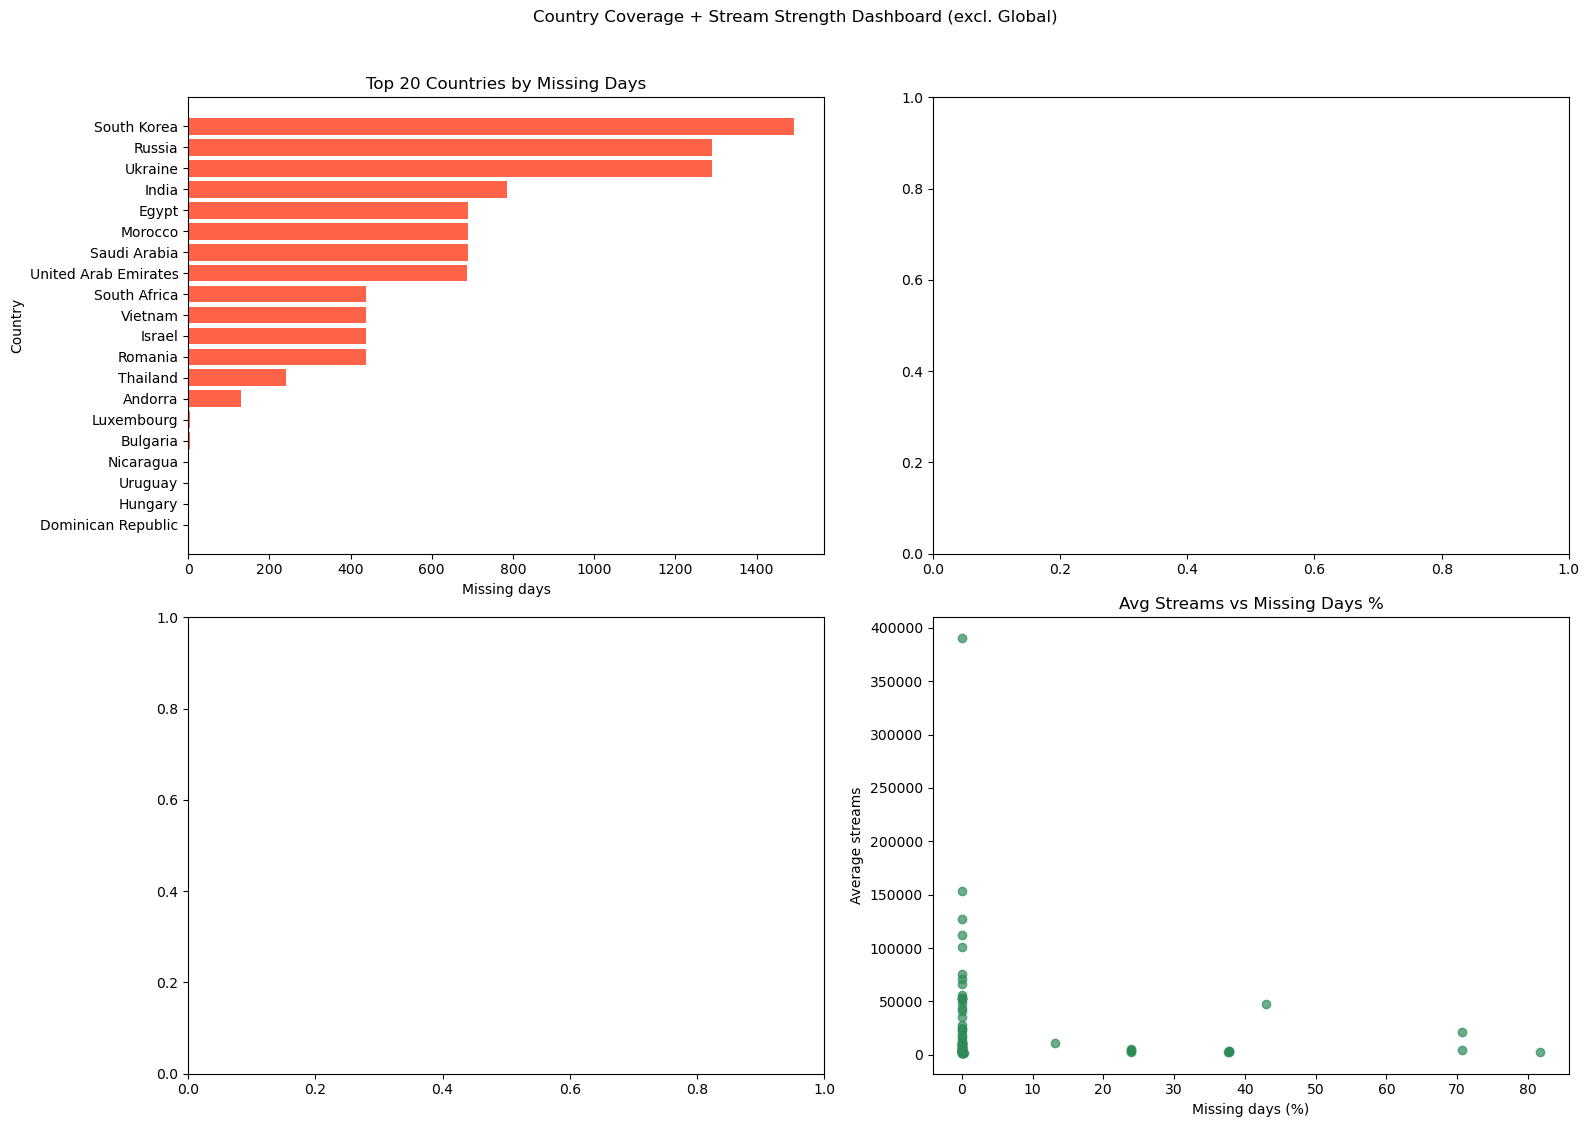

In [41]:
coverage_by_country_df = con.execute("""
WITH base AS (
    SELECT
        region,
        COALESCE(
            TRY_CAST(date AS DATE),
            CASE
                WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1)
                ELSE NULL
            END
        ) AS event_date
    FROM spotify_full
    WHERE region IS NOT NULL
)
SELECT
    region,
    COUNT(*) AS chart_rows,
    COUNT(DISTINCT event_date) AS active_days,
    MIN(event_date) AS first_seen,
    MAX(event_date) AS last_seen
FROM base
WHERE event_date IS NOT NULL
GROUP BY region
ORDER BY chart_rows DESC;
""").df()
# 3.2.1 Integrated country diagnostics table + dashboard
country_stream_stats_df = con.execute("""
SELECT
    region,
    COUNT(*) AS n_entries,
    AVG(TRY_CAST(streams AS DOUBLE)) AS avg_streams,
    MEDIAN(TRY_CAST(streams AS DOUBLE)) AS median_streams,
    MAX(TRY_CAST(streams AS BIGINT)) AS max_streams,
    SUM(TRY_CAST(streams AS BIGINT)) AS total_streams
FROM spotify_full
WHERE streams IS NOT NULL
  AND track_id IS NOT NULL
  AND region IS NOT NULL
GROUP BY region;
""").df()

missing_days_by_country_df = con.execute("""
WITH date_bounds AS (
    SELECT
        MIN(COALESCE(
            TRY_CAST(date AS DATE),
            CASE WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1) END
        )) AS min_date,
        MAX(COALESCE(
            TRY_CAST(date AS DATE),
            CASE WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1) END
        )) AS max_date
    FROM spotify_full
),
country_activity AS (
    SELECT
        region,
        COUNT(DISTINCT COALESCE(
            TRY_CAST(date AS DATE),
            CASE WHEN TRY_CAST(year AS INTEGER) IS NOT NULL THEN MAKE_DATE(TRY_CAST(year AS INTEGER), 1, 1) END
        )) AS active_days
    FROM spotify_full
    WHERE region IS NOT NULL
    GROUP BY region
)
SELECT
    ca.region,
    db.min_date,
    db.max_date,
    DATE_DIFF('day', db.min_date, db.max_date) + 1 AS expected_days,
    ca.active_days,
    (DATE_DIFF('day', db.min_date, db.max_date) + 1) - ca.active_days AS missing_days,
    ROUND(
        100.0 * ((DATE_DIFF('day', db.min_date, db.max_date) + 1) - ca.active_days)
        / (DATE_DIFF('day', db.min_date, db.max_date) + 1),
        2
    ) AS missing_days_pct
FROM country_activity ca
CROSS JOIN date_bounds db;
""").df()

country_diagnostics_df = (
    coverage_by_country_df
    .merge(missing_days_by_country_df[["region", "expected_days", "missing_days", "missing_days_pct"]], on="region", how="left")
    .merge(country_stream_stats_df, on="region", how="left")
)

# Exclude global for country-comparison views
country_diagnostics_no_global_df = country_diagnostics_df[
    country_diagnostics_df["region"].str.lower() != "global"
].copy()

# Neat summary table (most relevant fields)
country_diagnostics_display_df = country_diagnostics_no_global_df[[
    "region", "first_seen", "last_seen", "chart_rows", "active_days", "expected_days", "missing_days", "missing_days_pct",
    "avg_streams", "median_streams", "total_streams"
]].sort_values(["missing_days", "avg_streams"], ascending=[False, False])

print("Integrated country diagnostics (top 25 by missing days):")
display(country_diagnostics_display_df.head(25))

# ---- Graph dashboard ----
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# 1) Missing days (top 20)
plot_missing = country_diagnostics_no_global_df.sort_values("missing_days", ascending=False).head(20)
axes[0, 0].barh(plot_missing["region"][::-1], plot_missing["missing_days"][::-1], color="tomato")
axes[0, 0].set_title("Top 20 Countries by Missing Days")
axes[0, 0].set_xlabel("Missing days")
axes[0, 0].set_ylabel("Country")

# 2) Average streams (top 20)
'''plot_avg = country_diagnostics_no_global_df.sort_values("avg_streams", ascending=False).head(20)
axes[0, 1].barh(plot_avg["region"][::-1], plot_avg["avg_streams"][::-1], color="steelblue")
axes[0, 1].set_title("Top 20 Countries by Average Streams")
axes[0, 1].set_xlabel("Average streams")
axes[0, 1].set_ylabel("Country")

# 3) Median streams (top 20)
plot_median = country_diagnostics_no_global_df.sort_values("median_streams", ascending=False).head(20)
axes[1, 0].barh(plot_median["region"][::-1], plot_median["median_streams"][::-1], color="salmon")
axes[1, 0].set_title("Top 20 Countries by Median Streams")
axes[1, 0].set_xlabel("Median streams")
axes[1, 0].set_ylabel("Country")
'''
# 4) Data completeness vs stream strength
axes[1, 1].scatter(
    country_diagnostics_no_global_df["missing_days_pct"],
    country_diagnostics_no_global_df["avg_streams"],
    alpha=0.7,
    color="seagreen"
)
axes[1, 1].set_title("Avg Streams vs Missing Days %")
axes[1, 1].set_xlabel("Missing days (%)")
axes[1, 1].set_ylabel("Average streams")

plt.suptitle("Country Coverage + Stream Strength Dashboard (excl. Global)", y=1.02)
plt.tight_layout()
plt.show()

In [13]:

# ── One sample entry per distinct null-count group — displayed side by side ───
# Collect one sample row per group, then concatenate into a wide comparison table.

samples = {}

for n_nulls in null_dist["n_nulls_in_row"].tolist():
    n_rows = int(null_dist.loc[null_dist["n_nulls_in_row"] == n_nulls, "n_rows"].values[0])

    row = con.execute(f"""
        SELECT *
        FROM spotify_full
        WHERE ({null_count_expr}) = {n_nulls}
        LIMIT 1
    """).df().iloc[0]

    col_label = f"{n_nulls} nulls\n({n_rows:,} rows)"
    samples[col_label] = row

# Build wide DataFrame: rows = columns of spotify_full, columns = null-count groups
wide = pd.DataFrame(samples)

# Highlight null cells in red
def highlight_nulls(df):
    return df.map(lambda v: "background-color: #ffcccc; color: #cc0000" if pd.isna(v) else "")

display(
    wide.style
    .apply(highlight_nulls, axis=None)
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "11px"), ("text-align", "center"), ("white-space", "pre-wrap")]},
        {"selector": "td", "props": [("font-size", "10px"), ("max-width", "160px"),
                                      ("overflow", "hidden"), ("text-overflow", "ellipsis"),
                                      ("white-space", "nowrap")]},
    ])
    .set_caption("Sample entry per null-count group — red cells are NULL")
)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

AttributeError: 'DataFrame' object has no attribute 'map'

Not all countries have cultural distance measures, these countries can be removed. 

### 7.3 Duplicates

In [14]:
# Check for duplicate entries (same song, country, date, chart)
print("  DUPLICATE CHECK — (track_id, region, date, chart)")
print("═" * 60)

# 1. Total rows vs distinct combinations
totals = con.execute("""
    SELECT
        COUNT(*) AS total_rows,
        COUNT(DISTINCT (track_id, region, date, chart)) AS distinct_combinations
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
""").df()

total     = int(totals["total_rows"][0])
distinct  = int(totals["distinct_combinations"][0])
dupes     = total - distinct

print(f"\n  Total rows (excl. NULL streams/track_id) : {total:>12,}")
print(f"  Distinct combinations                    : {distinct:>12,}")
print(f"  Duplicate rows                           : {dupes:>12,}  ({dupes/total*100:.2f}%)")

# 2. Top 20 most duplicated combinations
print("\n── Top 20 most duplicated (track_id, region, date, chart) ──")
top_dupes = con.execute("""
    SELECT
        track_id,
        region,
        date,
        chart,
        COUNT(*) AS n_entries,
        MIN(TRY_CAST(streams AS BIGINT)) AS streams_min,
        MAX(TRY_CAST(streams AS BIGINT)) AS streams_max
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
    GROUP BY track_id, region, date, chart
    HAVING COUNT(*) > 1
    ORDER BY n_entries DESC
""").df()

if top_dupes.empty:
    print("No duplicates found!")
else:
    print(f"{len(top_dupes):,} duplicate groups found (showing top 20)")
    display(top_dupes)

# 3. Are stream values identical across duplicates, or do they differ?
print("\n── Do duplicate rows have conflicting stream values? ────────")
conflict_check = con.execute("""
    SELECT
        COUNT(*) AS groups_with_conflicting_streams
    FROM (
        SELECT track_id, region, date, chart
        FROM spotify_full
        WHERE streams IS NOT NULL
          AND track_id IS NOT NULL
        GROUP BY track_id, region, date, chart
        HAVING COUNT(*) > 1
          AND MIN(TRY_CAST(streams AS BIGINT)) != MAX(TRY_CAST(streams AS BIGINT))
    )
""").fetchone()[0]

if conflict_check == 0:
    print("All duplicate rows have identical stream values (safe to deduplicate).")
else:
    print(f"{conflict_check:,} groups have DIFFERENT stream values — inspect before dropping!")

  DUPLICATE CHECK — (track_id, region, date, chart)
════════════════════════════════════════════════════════════


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


  Total rows (excl. NULL streams/track_id) :   20,318,921
  Distinct combinations                    :   20,318,864
  Duplicate rows                           :           57  (0.00%)

── Top 20 most duplicated (track_id, region, date, chart) ──


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

57 duplicate groups found (showing top 20)


,track_id,region,date,chart,n_entries,streams_min,streams_max
0,4hGyLmElEHdBf29ubQ61Yq,Peru,2017-10-05,top200,2,13329,13329
1,3ZVrELQ8ncJNY0K6oWgHSB,Singapore,2017-09-01,top200,2,3917,3917
2,3JGE1pWIf4Z6JqjIz6f1F4,Germany,2017-09-01,top200,2,81942,81942
3,6w40GgWhGts8g6779DPXR3,Israel,2018-03-14,top200,2,1232,1232
4,3ZVrELQ8ncJNY0K6oWgHSB,Taiwan,2017-09-01,top200,2,2552,2552
5,7mIFzHyC5luAXh0jIMj6XY,Ireland,2017-09-01,top200,2,3746,3746
6,5RwZ97IdwhGxQWsvSXBokl,Paraguay,2017-09-02,top200,2,1621,1621
7,3JGE1pWIf4Z6JqjIz6f1F4,Germany,2017-09-02,top200,2,52446,52446
8,3JGE1pWIf4Z6JqjIz6f1F4,Germany,2017-09-03,top200,2,37595,37595
9,6w40GgWhGts8g6779DPXR3,Israel,2018-03-18,top200,2,1093,1093



── Do duplicate rows have conflicting stream values? ────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

All duplicate rows have identical stream values (safe to deduplicate).


### 7.4 Snapshot and Example Entries

In [15]:
TRACK_ID = "6mICuAdrwEjh6Y6lroV2Kg"

all_entries = con.execute(f"""
    SELECT title, date, track_id, region, chart, artist,
           TRY_CAST(streams AS BIGINT) AS streams,
           year
    FROM spotify_full
    WHERE track_id = '{TRACK_ID}'
      AND date = '2017-02-04'
    ORDER BY streams DESC
    LIMIT 10
""").df()

print(f"Total entries found for track, this is with the limit: {len(all_entries):,}")
display(all_entries)

Total entries found for track, this is with the limit: 10


,title,date,track_id,region,chart,artist,streams,year
0,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Global,top200,Shakira,2525024,2017
1,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Mexico,top200,Shakira,392920,2017
2,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,United States,top200,Shakira,335450,2017
3,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Spain,top200,Shakira,283435,2017
4,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Germany,top200,Shakira,184731,2017
5,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Argentina,top200,Shakira,179411,2017
6,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Brazil,top200,Shakira,152974,2017
7,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Chile,top200,Shakira,129493,2017
8,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,France,top200,Shakira,94284,2017
9,Chantaje (feat. Maluma),2017-02-04,6mICuAdrwEjh6Y6lroV2Kg,Netherlands,top200,Shakira,87131,2017


In [16]:
# Total streams across all countries (excluding global) 
total_streams = con.execute(f"""
    SELECT SUM(TRY_CAST(streams AS BIGINT)) AS total_streams
    FROM spotify_full
    WHERE track_id = '{TRACK_ID}'
      AND date = '2017-02-04'
      AND LOWER(region) != 'global'
""").fetchone()[0]

print(f"Total streams for track '{TRACK_ID}' on 2017-02-04 (excl. global): {total_streams:,}")

Total streams for track '6mICuAdrwEjh6Y6lroV2Kg' on 2017-02-04 (excl. global): 2,520,622


The spotify top 200 global list streams is roughly an aggregation of all other countries top 200 streams.

### 7.5 Spread of streams

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

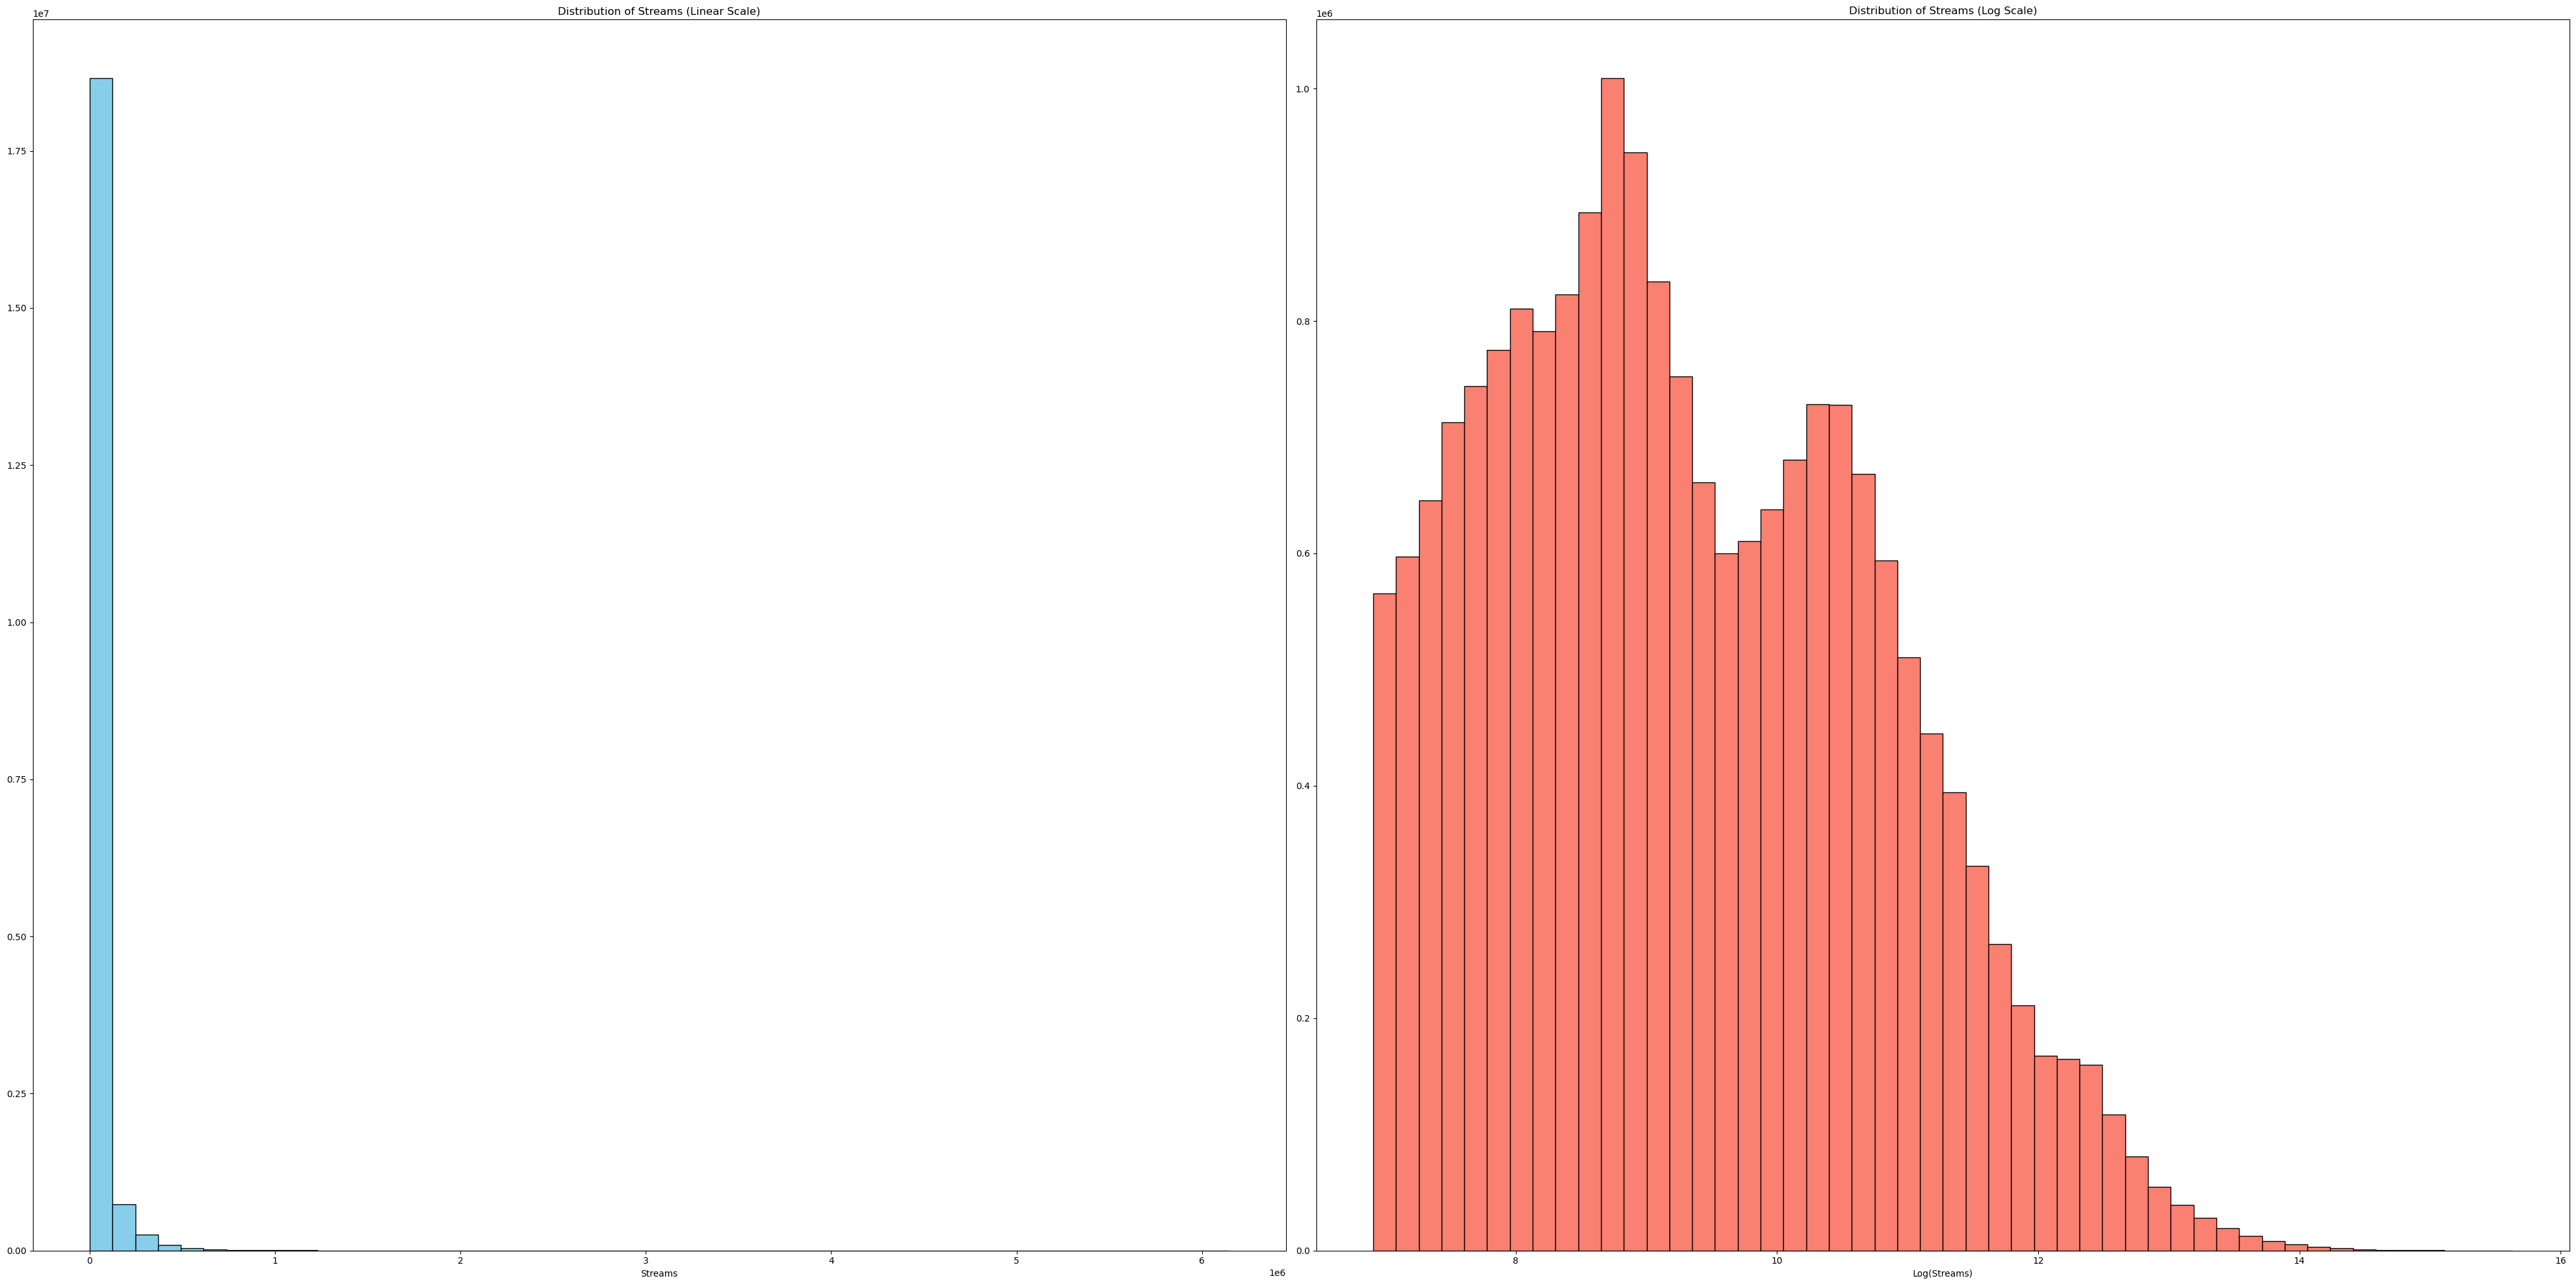

In [17]:
# Sample the data for visualization (as the dataset is too big for full pandas plotting)
sample_df = con.execute("SELECT TRY_CAST(streams AS DOUBLE) as streams FROM spotify_full WHERE streams IS NOT NULL AND LOWER (region) != 'global' USING SAMPLE 26000000").df()

plt.figure(figsize=(40, 20))

# Plot 1: Standard Distribution
plt.subplot(1, 2, 1)
plt.hist(sample_df['streams'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Streams (Linear Scale)")
plt.xlabel("Streams")

# Plot 2: Log Distribution 
plt.subplot(1, 2, 2)
plt.hist(np.log1p(sample_df['streams']), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution of Streams (Log Scale)")
plt.xlabel("Log(Streams)")

plt.tight_layout()
plt.show()

These are all daily streams mapped accross countries. The distribution is heavily skewed because some songs are played 6 million times e.g. Drake in the US while most entries are from smaller countries where streams are significantly lower e.g., Andorra. See the distribution below. 

── Stream value percentiles (full dataset) ──────────────────


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,p50,p90,p95,p99,p999,max_streams
0,9201.0,81240.0,141359.0,355946.44,909675.222,6146233.0



── Top 20 highest-stream entries ────────────────────────────


,date,title,artist,region,chart,rank,streams,year
0,2021-09-03,Girls Want Girls (with Lil Baby),Drake,United States,top200,1,6146233,2021
1,2021-01-12,drivers license,Olivia Rodrigo,United States,top200,1,6145601,2021
2,2021-09-03,Champagne Poetry,Drake,United States,top200,2,5953619,2021
3,2018-06-29,Nonstop,Drake,United States,top200,1,5749019,2018
4,2021-01-13,drivers license,Olivia Rodrigo,United States,top200,1,5723851,2021
5,2021-01-11,drivers license,Olivia Rodrigo,United States,top200,1,5688246,2021
6,2021-09-03,Fair Trade (with Travis Scott),Drake,United States,top200,3,5616734,2021
7,2021-10-15,Easy On Me,Adele,United States,top200,1,5435431,2021
8,2021-01-14,drivers license,Olivia Rodrigo,United States,top200,1,5271136,2021
9,2018-06-29,Survival,Drake,United States,top200,2,5219711,2018



── Entries above stream thresholds ──────────────────────────
  streams >    6,000,000 :        2 entries
  streams >    3,000,000 :      275 entries
  streams >    1,000,000 :   15,037 entries
  streams >      500,000 :   94,398 entries

── Histogram of streams above the 99th percentile ──────────


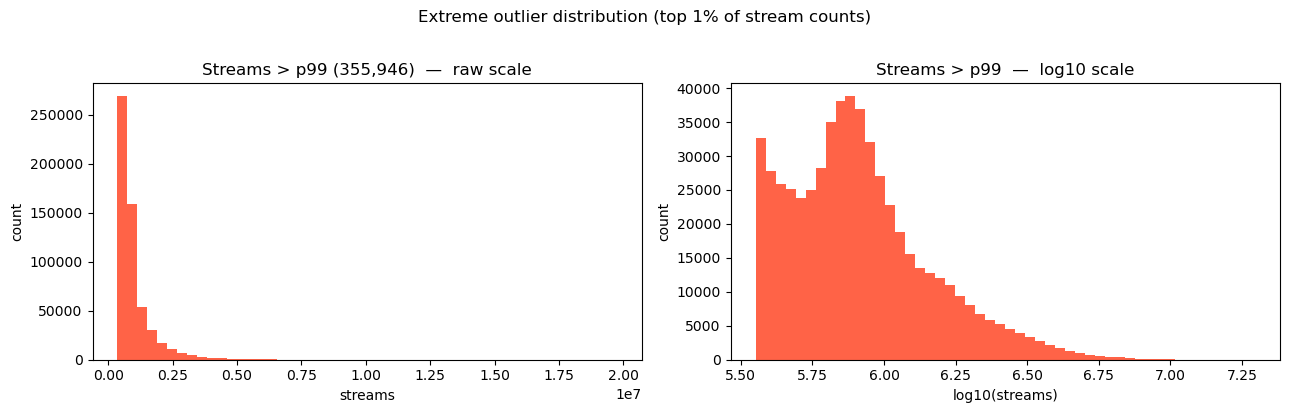


Note: The bulk of data sits around 9,201 streams (median).
The very top entries reach 6,146,233 streams — ~668× the median.


In [18]:
# 1. Key percentiles to see where the tail starts
print("── Stream value percentiles (full dataset) ──────────────────")
pcts = con.execute("""
    SELECT
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p50,
        PERCENTILE_CONT(0.90) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p90,
        PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p95,
        PERCENTILE_CONT(0.99) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p99,
        PERCENTILE_CONT(0.999) WITHIN GROUP (ORDER BY TRY_CAST(streams AS DOUBLE)) AS p999,
        MAX(TRY_CAST(streams AS DOUBLE)) AS max_streams
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) != 'global'
""").df()
display(pcts)

# 2. Top 20 individual entries by stream count
print("\n── Top 20 highest-stream entries ────────────────────────────")
top20 = con.execute("""
    SELECT
        date,
        title,
        artist,
        region,
        chart,
        TRY_CAST(rank    AS INTEGER) AS rank,
        TRY_CAST(streams AS BIGINT)  AS streams,
        year
    FROM spotify_full
    WHERE streams IS NOT NULL AND LOWER(region) != 'global'
    ORDER BY TRY_CAST(streams AS DOUBLE) DESC
    LIMIT 20
""").df()
display(top20)

# 3. How many entries exceed common "suspicious" thresholds?
print("\n── Entries above stream thresholds ──────────────────────────")
thresholds = [6_000_000, 3_000_000, 1_000_000, 500_000]
for t in thresholds:
    n = con.execute(f"""
        SELECT COUNT(*) FROM spotify_full
        WHERE TRY_CAST(streams AS DOUBLE) > {t} AND LOWER(region) != 'global'
    """).fetchone()[0]
    print(f"  streams > {t:>12,} : {n:>8,} entries")

# 4. Distribution of the top 1% visually
print("\n── Histogram of streams above the 99th percentile ──────────")
p99_val = float(pcts["p99"].iloc[0])
top1pct = con.execute(f"""
    SELECT TRY_CAST(streams AS DOUBLE) AS streams
    FROM spotify_full
    WHERE TRY_CAST(streams AS DOUBLE) > {p99_val}
      AND streams IS NOT NULL 
""").df()

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(top1pct["streams"], bins=50, color="tomato", edgecolor="none")
axes[0].set_title(f"Streams > p99 ({p99_val:,.0f})  —  raw scale")
axes[0].set_xlabel("streams")
axes[0].set_ylabel("count")

axes[1].hist(np.log10(top1pct["streams"]), bins=50, color="tomato", edgecolor="none")
axes[1].set_title("Streams > p99  —  log10 scale")
axes[1].set_xlabel("log10(streams)")
axes[1].set_ylabel("count")

plt.suptitle("Extreme outlier distribution (top 1% of stream counts)", y=1.02)
plt.tight_layout()
plt.show()

print(f"\nNote: The bulk of data sits around {float(pcts['p50'].iloc[0]):,.0f} streams (median).")
print(f"The very top entries reach {int(pcts['max_streams'].iloc[0]):,} streams — "
      f"~{int(pcts['max_streams'].iloc[0]) / float(pcts['p50'].iloc[0]):.0f}× the median.")

## 8. Analysis and Findings

### 8.1 Country Analysis

════════════════════════════════════════════════════════════
  AVERAGE STREAMS PER COUNTRY
════════════════════════════════════════════════════════════

  Total countries: 68


,region,n_entries,avg_streams,median_streams,max_streams,total_streams
0,United States,364081,390255.989208,294790.0,6146233,1.420848e+11
1,Brazil,364503,153263.777791,111785.0,2001683,5.586511e+10
2,Mexico,358331,127242.997592,97308.0,3680758,4.559511e+10
3,Germany,357342,111799.026311,80791.5,2629922,3.995049e+10
4,United Kingdom,359715,101198.344323,70095.0,2801638,3.640256e+10
...,...,...,...,...,...,...
63,Lithuania,152993,1938.003046,1520.0,86013,2.965009e+08
64,Estonia,107995,1790.969452,1486.0,29525,1.934157e+08
65,Latvia,150974,1728.479407,1448.0,23558,2.609554e+08
66,Bulgaria,94834,1707.914661,1401.0,30203,1.619684e+08


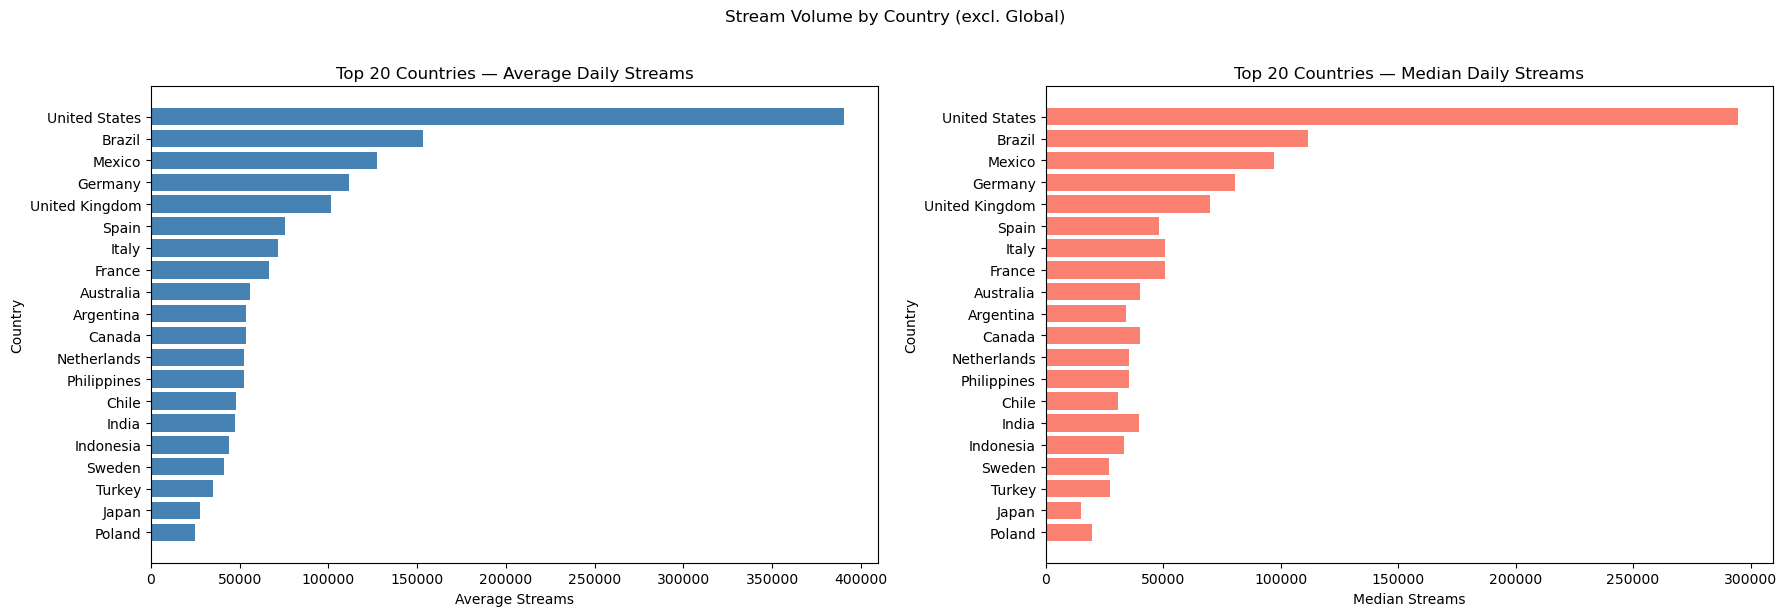


── Bottom 10 countries by average streams ───────────────────


,region,n_entries,avg_streams,median_streams,max_streams,total_streams
58,Egypt,123764,2551.200398,1936.0,74586,315746766.0
59,Slovakia,267583,2421.919012,1893.0,39470,648064355.0
60,United Arab Emirates,142051,2147.140823,1649.0,27573,305003501.0
61,Iceland,212061,2100.610112,1545.0,44069,445457481.0
62,Nicaragua,109995,2065.814528,1565.0,34289,227229269.0
63,Lithuania,152993,1938.003046,1520.0,86013,296500900.0
64,Estonia,107995,1790.969452,1486.0,29525,193415746.0
65,Latvia,150974,1728.479407,1448.0,23558,260955450.0
66,Bulgaria,94834,1707.914661,1401.0,30203,161968379.0
67,Luxembourg,8957,1658.866362,1386.0,16701,14858466.0


In [19]:
# Average streams per country (excluding global) 
print("═" * 60)
print("  AVERAGE STREAMS PER COUNTRY")
print("═" * 60)

avg_streams_country = con.execute("""
    SELECT
        region,
        COUNT(*)                                          AS n_entries,
        AVG(TRY_CAST(streams AS DOUBLE))                 AS avg_streams,
        MEDIAN(TRY_CAST(streams AS DOUBLE))              AS median_streams,
        MAX(TRY_CAST(streams AS BIGINT))                 AS max_streams,
        SUM(TRY_CAST(streams AS BIGINT))                 AS total_streams
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND track_id IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY region
    ORDER BY avg_streams DESC
""").df()

print(f"\n  Total countries: {len(avg_streams_country):,}")
display(avg_streams_country)

# Bar chart: Top 20 countries by average streams 
top20 = avg_streams_country.head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Average streams
axes[0].barh(top20["region"][::-1], top20["avg_streams"][::-1], color="steelblue")
axes[0].set_title("Top 20 Countries — Average Daily Streams")
axes[0].set_xlabel("Average Streams")
axes[0].set_ylabel("Country")

# Median streams (less affected by outliers)
axes[1].barh(top20["region"][::-1], top20["median_streams"][::-1], color="salmon")
axes[1].set_title("Top 20 Countries — Median Daily Streams")
axes[1].set_xlabel("Median Streams")
axes[1].set_ylabel("Country")

plt.suptitle("Stream Volume by Country (excl. Global)", y=1.02)
plt.tight_layout()
plt.show()

# Bottom 10 countries by average streams 
print("\n── Bottom 10 countries by average streams ───────────────────")
display(avg_streams_country.tail(10))

In [20]:
# ── Shortest & Longest chart stay for a single song in any one country ────────
# span_days = (last chart date − first chart date) + 1  for a given track × country
# "Shortest" = songs that appeared only 1 day in a country (span_days = 1)
# We show the top 10 on each end, plus the single extreme examples.

extremes = con.execute("""
    WITH song_spans AS (
        SELECT
            track_id,
            MAX(title)                                                           AS title,
            MAX(artist)                                                          AS artist,
            region,
            MIN(TRY_CAST(date AS DATE))                                          AS first_date,
            MAX(TRY_CAST(date AS DATE))                                          AS last_date,
            DATEDIFF('day',
                     MIN(TRY_CAST(date AS DATE)),
                     MAX(TRY_CAST(date AS DATE))) + 1                            AS span_days,
            COUNT(*)                                                             AS chart_entries,
            ROUND(AVG(TRY_CAST(rank AS DOUBLE)), 1)                              AS avg_rank
        FROM spotify_full
        WHERE region IS NOT NULL
          AND LOWER(region) != 'global'
          AND track_id IS NOT NULL
          AND title IS NOT NULL
          AND streams IS NOT NULL
        GROUP BY track_id, region
    )
    SELECT * FROM song_spans
    ORDER BY span_days DESC, chart_entries DESC
""").df()

# ── LONGEST stay ──────────────────────────────────────────────────────────────
print("═" * 70)
print("  TOP 10 LONGEST CHART STAYS — single song in a single country")
print("═" * 70)
longest = extremes.head(10)[["title", "artist", "region", "first_date",
                               "last_date", "span_days", "chart_entries", "avg_rank"]]
display(longest.reset_index(drop=True))

# ── SHORTEST stay (span_days = 1, i.e. appeared on exactly one date) ──────────
print("\n" + "═" * 70)
print("  SONGS WITH THE SHORTEST CHART STAY (appeared on only 1 day in a country)")
print("═" * 70)

one_day = extremes[extremes["span_days"] == 1].copy()
print(f"\n  Total (track × country) combos with a 1-day stay : {len(one_day):,}")
print(f"  Distinct tracks                                   : {one_day['track_id'].nunique():,}")
print(f"  Distinct countries                                : {one_day['region'].nunique():,}")
print("\n  Sample of 10 one-day chart appearances:")
display(
    one_day[["title", "artist", "region", "first_date", "chart_entries", "avg_rank"]]
    .head(10)
    .reset_index(drop=True)
)

# ── Summary banner ────────────────────────────────────────────────────────────
longest_row  = extremes.iloc[0]
shortest_row = one_day.sort_values("chart_entries").iloc[0]

print("\n" + "═" * 70)
print("  SUMMARY")
print("═" * 70)
print(f"\n  Longest single-country chart run:")
print(f"     Song    : {longest_row['title']}")
print(f"     Artist  : {longest_row['artist']}")
print(f"     Country : {longest_row['region']}")
print(f"     Period  : {longest_row['first_date']}  →  {longest_row['last_date']}")
print(f"     Span    : {int(longest_row['span_days'])} days  ({int(longest_row['chart_entries'])} chart entries)")

print(f"\n  ⚡ Shortest single-country chart run (1 day):")
print(f"     Song    : {shortest_row['title']}")
print(f"     Artist  : {shortest_row['artist']}")
print(f"     Country : {shortest_row['region']}")
print(f"     Date    : {shortest_row['first_date']}")
print(f"     Entries : {int(shortest_row['chart_entries'])}  (avg rank {shortest_row['avg_rank']})")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

══════════════════════════════════════════════════════════════════════
  TOP 10 LONGEST CHART STAYS — single song in a single country
══════════════════════════════════════════════════════════════════════


,title,artist,region,first_date,last_date,span_days,chart_entries,avg_rank
0,Ohne mein Team,"Bonez MC, RAF Camora, Maxwell",Austria,2017-01-01,2021-12-31,1826,1806,96.4
1,goosebumps,Travis Scott,United States,2017-01-01,2021-12-31,1826,1778,97.1
2,No Role Modelz,J. Cole,United States,2017-01-01,2021-12-31,1826,1474,128.7
3,Don't Stop Believin',Journey,Austria,2017-01-01,2021-12-31,1826,878,173.0
4,Without Me,Eminem,Austria,2017-01-01,2021-12-31,1826,532,166.1
5,Ocho Cuarenta,Rodrigo,Argentina,2017-01-01,2021-12-31,1826,503,150.1
6,Una Cerveza,Rafaga,Argentina,2017-01-01,2021-12-31,1826,484,150.0
7,Deja De Llorar,El Polaco,Argentina,2017-01-01,2021-12-31,1826,294,147.9
8,Die For You,The Weeknd,United States,2017-01-01,2021-12-31,1826,282,155.7
9,Noche Loca,"Marama, Rombai",Argentina,2017-01-01,2021-12-31,1826,271,137.8



══════════════════════════════════════════════════════════════════════
  SONGS WITH THE SHORTEST CHART STAY (appeared on only 1 day in a country)
══════════════════════════════════════════════════════════════════════

  Total (track × country) combos with a 1-day stay : 76,989
  Distinct tracks                                   : 39,010
  Distinct countries                                : 68

  Sample of 10 one-day chart appearances:


,title,artist,region,first_date,chart_entries,avg_rank
0,No Man is an Island,The Script,Ireland,2017-09-01,2,168.0
1,Deborah,Casper,Austria,2017-09-01,2,163.0
2,BABE,HyunA,Taiwan,2017-09-26,2,184.0
3,No Man is an Island,The Script,Netherlands,2017-09-01,2,171.0
4,No Man is an Island,The Script,Thailand,2017-09-01,2,100.0
5,Wicked Game,Chris Isaak,Sweden,2017-09-20,2,168.0
6,Love Not Lovers,The Script,Taiwan,2017-09-01,2,199.0
7,Love Not Lovers,The Script,Netherlands,2017-09-01,2,150.0
8,Love Not Lovers,The Script,Singapore,2017-09-01,2,183.0
9,No Man is an Island,The Script,Malaysia,2017-09-01,2,155.0



══════════════════════════════════════════════════════════════════════
  SUMMARY
══════════════════════════════════════════════════════════════════════

  Longest single-country chart run:
     Song    : Ohne mein Team
     Artist  : Bonez MC, RAF Camora, Maxwell
     Country : Austria
     Period  : 2017-01-01 00:00:00  →  2021-12-31 00:00:00
     Span    : 1826 days  (1806 chart entries)

  ⚡ Shortest single-country chart run (1 day):
     Song    : Instinkt
     Artist  : Haze
     Country : Germany
     Date    : 2021-10-08 00:00:00
     Entries : 1  (avg rank 158.0)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

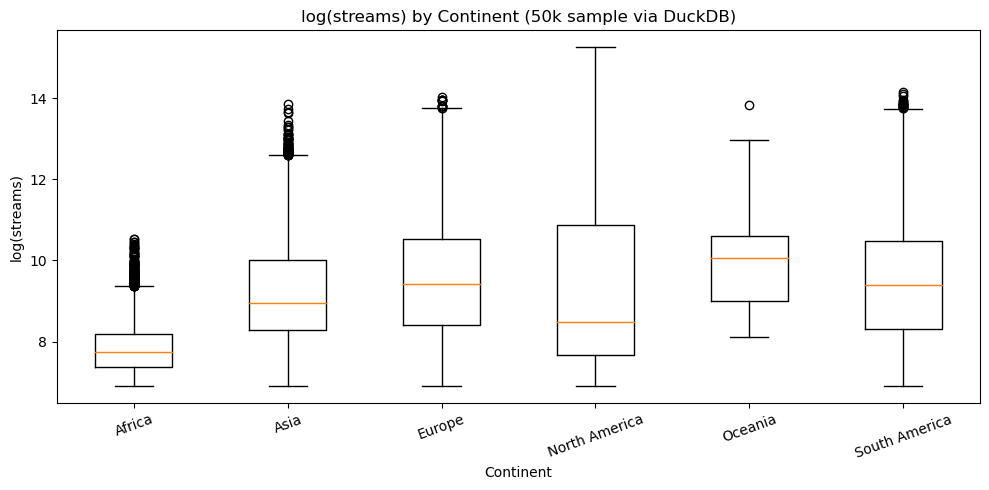

In [21]:
continent_df = con.execute("""
    SELECT
        LN(TRY_CAST(streams AS DOUBLE)) AS log_streams,
        country_continent
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND TRY_CAST(streams AS DOUBLE) > 0
      AND LOWER(region) != 'global'
      AND country_continent IS NOT NULL
    USING SAMPLE 500000
""").df()

continents = sorted(continent_df["country_continent"].dropna().unique())
groups = [
    continent_df.loc[continent_df["country_continent"] == c, "log_streams"].dropna().values
    for c in continents
]

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(groups, labels=continents, vert=True)
ax.set_title("log(streams) by Continent (50k sample via DuckDB)")
ax.set_xlabel("Continent")
ax.set_ylabel("log(streams)")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()


The country analysis reveals strong heterogeneity in average and median daily streams across markets. The United States dominates by a large margin, followed by Brazil, Mexico, Germany, and the United Kingdom. These markets show substantially higher stream volumes compared to smaller European countries such as Luxembourg, Bulgaria, or Latvia.

The gap between mean and median streams suggests that larger markets are more influenced by viral outliers, whereas smaller markets exhibit more stable but lower stream distributions. The observed differences in stream volume are consistent with variations in population size and overall platform penetration, indicating that structural market characteristics play an important role.

Overall, these findings indicate that international rollout decisions cannot treat countries uniformly. Market-specific dynamics significantly influence stream performance, reinforcing the importance of a data-driven system that ranks target markets based on expected impact and timing.

### 8.2 Artist Analysis

═════════════════════════════════════════════════════════════════
  1) BIGGEST ARTISTS IN THE DATA
═════════════════════════════════════════════════════════════════

  Total unique artists: 39,890

── Top 20 artists by chart appearances ──────────────────────


,artist,chart_appearances,unique_songs,countries_reached,active_days,avg_rank,total_streams
0,Ed Sheeran,355703,123,68,1823,95.7,1.051741e+10
1,Billie Eilish,222671,67,68,1404,93.7,7.527774e+09
2,Post Malone,189243,71,68,1823,88.7,9.338347e+09
3,Bad Bunny,184950,62,65,1823,84.0,5.150676e+09
4,Dua Lipa,169748,47,68,1823,82.9,5.605296e+09
5,Ariana Grande,169097,90,68,1823,85.9,7.015974e+09
6,Drake,150884,153,68,1822,83.4,8.866556e+09
7,Imagine Dragons,139994,89,68,1823,102.6,3.223163e+09
8,XXXTENTACION,135503,62,66,1797,108.9,5.499213e+09
9,The Weeknd,130631,59,68,1705,71.4,5.750073e+09



── Top 20 artists by unique songs ───────────────────────────


,artist,chart_appearances,unique_songs,countries_reached,active_days,avg_rank,total_streams
394,Jul,8003,257,5,1589,109.6,4.728192e+08
10,BTS,130056,230,68,1823,94.2,3.381890e+09
20,Taylor Swift,83198,214,68,1667,100.3,3.928982e+09
93,TWICE,27775,171,33,1810,105.7,5.045369e+08
6,Drake,150884,153,68,1822,83.4,8.866556e+09
8685,Die drei ???,179,138,1,35,166.0,9.696489e+06
13,Juice WRLD,106780,123,68,1351,100.9,6.363268e+09
0,Ed Sheeran,355703,123,68,1823,95.7,1.051741e+10
722,Djadja & Dinaz,4710,121,4,1468,113.4,2.466783e+08
733,Tory Lanez,4650,116,42,1070,126.3,2.896469e+08


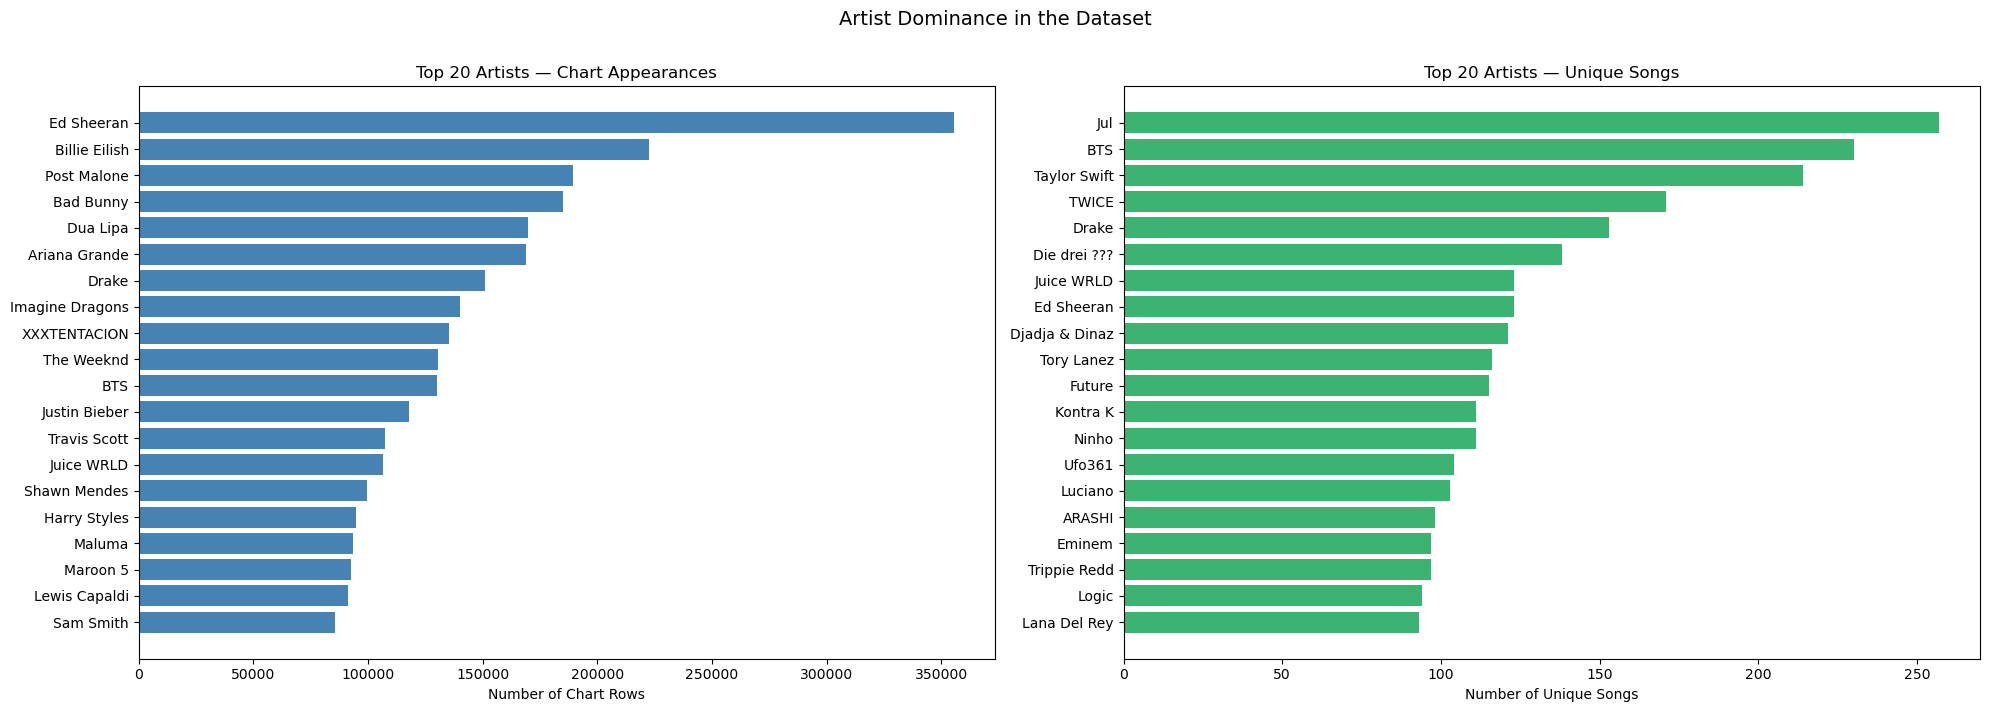

In [22]:
# 1. TOP ARTISTS BY CHART APPEARANCES & UNIQUE SONGS
print("═" * 65)
print("  1) BIGGEST ARTISTS IN THE DATA")
print("═" * 65)

top_artists_appearances = con.execute("""
    SELECT
        artist,
        COUNT(*)                        AS chart_appearances,
        COUNT(DISTINCT track_id)        AS unique_songs,
        COUNT(DISTINCT region)          AS countries_reached,
        COUNT(DISTINCT date)            AS active_days,
        ROUND(AVG(TRY_CAST(rank AS DOUBLE)), 1)    AS avg_rank,
        SUM(TRY_CAST(streams AS BIGINT))            AS total_streams
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND artist IS NOT NULL
      AND track_id IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY artist
    ORDER BY chart_appearances DESC
""").df()

print(f"\n  Total unique artists: {len(top_artists_appearances):,}")
print("\n── Top 20 artists by chart appearances ──────────────────────")
display(top_artists_appearances.head(20))

print("\n── Top 20 artists by unique songs ───────────────────────────")
display(top_artists_appearances.sort_values("unique_songs", ascending=False).head(20))

# Plot: Top 20 by appearances vs unique songs
top20_app  = top_artists_appearances.head(20)
top20_songs = top_artists_appearances.sort_values("unique_songs", ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].barh(top20_app["artist"][::-1], top20_app["chart_appearances"][::-1], color="steelblue")
axes[0].set_title("Top 20 Artists — Chart Appearances")
axes[0].set_xlabel("Number of Chart Rows")

axes[1].barh(top20_songs["artist"][::-1], top20_songs["unique_songs"][::-1], color="mediumseagreen")
axes[1].set_title("Top 20 Artists — Unique Songs")
axes[1].set_xlabel("Number of Unique Songs")

plt.suptitle("Artist Dominance in the Dataset", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

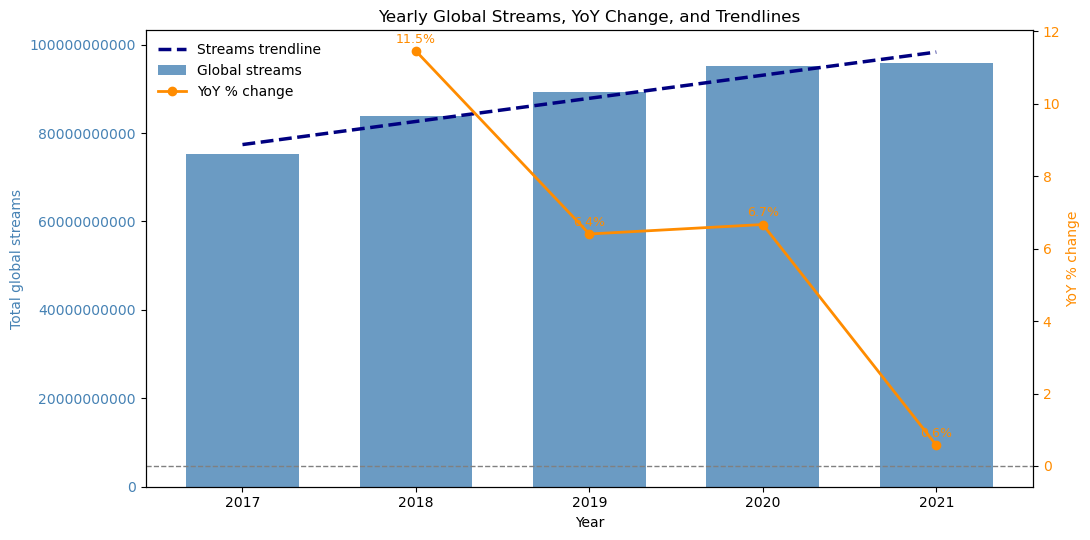

,year,global_streams,yoy_pct_change
0,2017,7.524887e+10,NaN
1,2018,8.387107e+10,11.458244
2,2019,8.924453e+10,6.406817
3,2020,9.519593e+10,6.668643
4,2021,9.574390e+10,0.575624


In [23]:
# Yearly global streams + YoY % difference with trendlines
yearly_global_streams_df = con.execute("""
WITH base AS (
    SELECT
        COALESCE(
            TRY_CAST(year AS INTEGER),
            EXTRACT(YEAR FROM TRY_CAST(date AS DATE))::INTEGER
        ) AS year_val,
        TRY_CAST(streams AS DOUBLE) AS streams_num
    FROM spotify_full
    WHERE LOWER(region) = 'global'
)
SELECT
    year_val AS year,
    SUM(streams_num) AS global_streams
FROM base
WHERE year_val IS NOT NULL
  AND streams_num IS NOT NULL
GROUP BY year_val
ORDER BY year_val;
""").df()

yearly_global_streams_df["yoy_pct_change"] = yearly_global_streams_df["global_streams"].pct_change() * 100

x_year = yearly_global_streams_df["year"].astype(int).values
y_streams = yearly_global_streams_df["global_streams"].values
y_yoy = yearly_global_streams_df["yoy_pct_change"].values

fig, ax1 = plt.subplots(figsize=(11, 5.5))

# Bars: yearly global streams
ax1.bar(x_year, y_streams, color="steelblue", alpha=0.8, width=0.65, label="Global streams")

# Trendline for global streams (linear)
coef_streams = np.polyfit(x_year, y_streams, 1)
trend_streams = np.polyval(coef_streams, x_year)
ax1.plot(x_year, trend_streams, color="navy", linewidth=2.5, linestyle="--", label="Streams trendline")

ax1.set_xlabel("Year")
ax1.set_ylabel("Total global streams", color="steelblue")
ax1.tick_params(axis="y", labelcolor="steelblue")
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_xticks(x_year)

# Line: YoY percentage change
ax2 = ax1.twinx()
ax2.plot(x_year, y_yoy, color="darkorange", marker="o", linewidth=2, label="YoY % change")


ax2.set_ylabel("YoY % change", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")
ax2.axhline(0, color="gray", linestyle="--", linewidth=1)

for x, y in zip(x_year, y_yoy):
    if pd.notnull(y):
        ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 6), ha="center", color="darkorange", fontsize=9)

# Combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left", frameon=False)

plt.title("Yearly Global Streams, YoY Change, and Trendlines")
fig.tight_layout()
plt.show()

display(yearly_global_streams_df)

The artist analysis shows strong concentration in chart dominance: although nearly 40,000 artists appear in the dataset, a small group of globally established artists accounts for a disproportionately large share of chart appearances and country reach. Top artists consistently chart across many countries and maintain long chart presence, while others show more localized or short-lived performance. There is substantial variability in the number of countries reached and the number of unique songs charting per artist. These differences highlight the importance of incorporating artist-level characteristics, such as prior chart history and international reach, when predicting cross-border breakout potential and rollout timing.

### 8.3 Country Spread Analysis

════════════════════════════════════════════════════════════
  SPREAD WIDTH PROPORTIONS
════════════════════════════════════════════════════════════

  Total songs analysed: 118,071

  Reach Tier                Songs        %   Cumulative %
  -------------------- ---------- -------- --------------
  1 country                86,347   73.13%         73.13%
  2–3 countries            17,810   15.08%         88.21%
  4–5 countries             3,809    3.23%         91.44%
  6–10 countries            3,354    2.84%         94.28%
  11–20 countries           3,158    2.67%         96.95%
  21–30 countries           1,217    1.03%         97.98%
  31–50 countries           1,496    1.27%         99.25%
  >50 countries               880    0.75%        100.00%


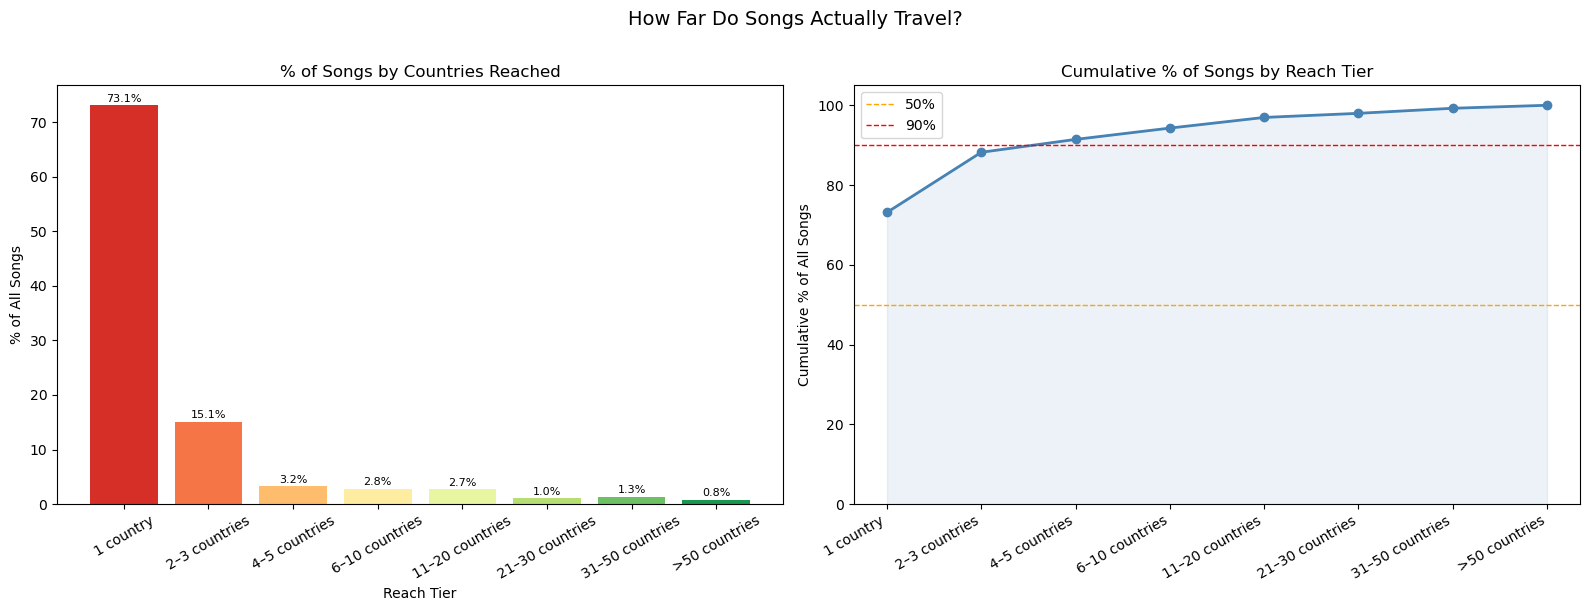


  Key takeaways:
  → 86,347 songs (73.1%) never left their first country
  → 2,376 songs (2.0%) reached more than 30 countries
  → Median reach: 1 countries
  → Mean reach  : 3.0 countries


In [49]:
# ── Compute spread (countries reached per song) via DuckDB ───────────────────
spread = con.execute("""
    WITH first_entry AS (
        SELECT
            track_id,
            artist,
            region,
            MIN(TRY_CAST(date AS DATE)) AS first_chart_date
        FROM spotify_full
        WHERE track_id  IS NOT NULL
          AND streams   IS NOT NULL
          AND region    IS NOT NULL
          AND LOWER(region) != 'global'
        GROUP BY track_id, artist, region
    ),
    global_debut AS (
        SELECT track_id, MIN(first_chart_date) AS global_debut
        FROM first_entry
        GROUP BY track_id
    ),
    travel AS (
        SELECT
            fe.track_id,
            fe.artist,
            fe.region,
            DATEDIFF('day', gd.global_debut, fe.first_chart_date) AS days_to_arrive
        FROM first_entry fe
        JOIN global_debut gd USING (track_id)
    ),
    origin AS (
        SELECT track_id, ANY_VALUE(region) AS origin_country
        FROM travel
        WHERE days_to_arrive = 0
        GROUP BY track_id
    )
    SELECT
        t.track_id,
        t.artist,
        o.origin_country,
        COUNT(DISTINCT t.region)                          AS countries_reached,
        MEDIAN(t.days_to_arrive)                          AS days_to_50pct,
        MAX(t.days_to_arrive)                             AS max_spread_days
    FROM travel t
    LEFT JOIN origin o USING (track_id)
    GROUP BY t.track_id, t.artist, o.origin_country
""").df()

# ── Spread Width Proportions — what % of songs reach how many countries ───────
print("═" * 60)
print("  SPREAD WIDTH PROPORTIONS")
print("═" * 60)

total_songs = len(spread)

# Define meaningful reach tiers
bins = [0, 1, 3, 5, 10, 20, 30, 50, float("inf")]
labels = ["1 country", "2–3 countries", "4–5 countries",
          "6–10 countries", "11–20 countries", "21–30 countries",
          "31–50 countries", ">50 countries"]

spread["reach_tier"] = pd.cut(
    spread["countries_reached"],
    bins=bins,
    labels=labels,
    right=True
)

tier_counts = (
    spread.groupby("reach_tier", observed=True)
    .size()
    .reset_index(name="n_songs")
)
tier_counts["pct"] = (tier_counts["n_songs"] / total_songs * 100).round(2)
tier_counts["cumulative_pct"] = tier_counts["pct"].cumsum().round(2)

print(f"\n  Total songs analysed: {total_songs:,}\n")
print(f"  {'Reach Tier':<20} {'Songs':>10} {'%':>8} {'Cumulative %':>14}")
print(f"  {'-'*20} {'-'*10} {'-'*8} {'-'*14}")
for _, row in tier_counts.iterrows():
    print(f"  {str(row['reach_tier']):<20} {int(row['n_songs']):>10,} {row['pct']:>7.2f}% {row['cumulative_pct']:>13.2f}%")

# ── Visualise ─────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.RdYlGn(np.linspace(0.1, 0.9, len(tier_counts)))

# Bar chart with % labels
bars = axes[0].bar(tier_counts["reach_tier"], tier_counts["pct"], color=colors, edgecolor="none")
axes[0].set_title("% of Songs by Countries Reached")
axes[0].set_xlabel("Reach Tier")
axes[0].set_ylabel("% of All Songs")
axes[0].tick_params(axis="x", rotation=30)
for bar, pct in zip(bars, tier_counts["pct"]):
    axes[0].text(bar.get_x() + bar.get_width() / 2,
                 bar.get_height() + 0.3,
                 f"{pct:.1f}%", ha="center", va="bottom", fontsize=8)

# Cumulative % line chart
axes[1].plot(tier_counts["reach_tier"], tier_counts["cumulative_pct"],
             marker="o", color="steelblue", linewidth=2)
axes[1].axhline(50,  color="orange", linestyle="--", linewidth=1, label="50%")
axes[1].axhline(90,  color="red",    linestyle="--", linewidth=1, label="90%")
axes[1].fill_between(range(len(tier_counts)), tier_counts["cumulative_pct"],
                     alpha=0.1, color="steelblue")
axes[1].set_xticks(range(len(tier_counts)))
axes[1].set_xticklabels(tier_counts["reach_tier"], rotation=30, ha="right")
axes[1].set_title("Cumulative % of Songs by Reach Tier")
axes[1].set_ylabel("Cumulative % of All Songs")
axes[1].set_ylim(0, 105)
axes[1].legend()

plt.suptitle("How Far Do Songs Actually Travel?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# ── Key takeaway numbers ──────────────────────────────────────────────────────
only_one   = int(tier_counts.loc[tier_counts["reach_tier"] == "1 country", "n_songs"].values[0])
over_thirty = spread[spread["countries_reached"] > 30].shape[0]
print(f"\n  Key takeaways:")
print(f"  → {only_one:,} songs ({only_one/total_songs*100:.1f}%) never left their first country")
print(f"  → {over_thirty:,} songs ({over_thirty/total_songs*100:.1f}%) reached more than 30 countries")
print(f"  → Median reach: {spread['countries_reached'].median():.0f} countries")
print(f"  → Mean reach  : {spread['countries_reached'].mean():.1f} countries")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

══════════════════════════════════════════════════════════════════════
  AVERAGE AUDIO FEATURES BY REACH TIER
══════════════════════════════════════════════════════════════════════


,danceability,energy,valence,acousticness,speechiness,instrumentalness,liveness,loudness,tempo
reach_tier,,,,,,,,,
1 country,0.6618,0.6311,0.5101,0.2900,0.1273,0.0279,0.1773,-7.3185,121.5131
2–3 countries,0.6893,0.6497,0.5056,0.2467,0.1526,0.0211,0.1725,-6.7631,121.9408
4–5 countries,0.6824,0.6451,0.5026,0.2418,0.1352,0.0169,0.1724,-6.5452,122.1950
6–10 countries,0.6617,0.6601,0.5103,0.2270,0.1045,0.0213,0.1802,-6.1563,121.9439
11–20 countries,0.6818,0.6633,0.5406,0.2329,0.1129,0.0169,0.1761,-5.9922,122.5757
21–30 countries,0.6578,0.6422,0.4711,0.2225,0.1218,0.0104,0.1854,-6.4562,120.2102
31–50 countries,0.6555,0.6192,0.4604,0.2351,0.1142,0.0152,0.1840,-6.6012,119.8394
>50 countries,0.6701,0.6264,0.4765,0.2279,0.1008,0.0107,0.1665,-6.3308,121.1352


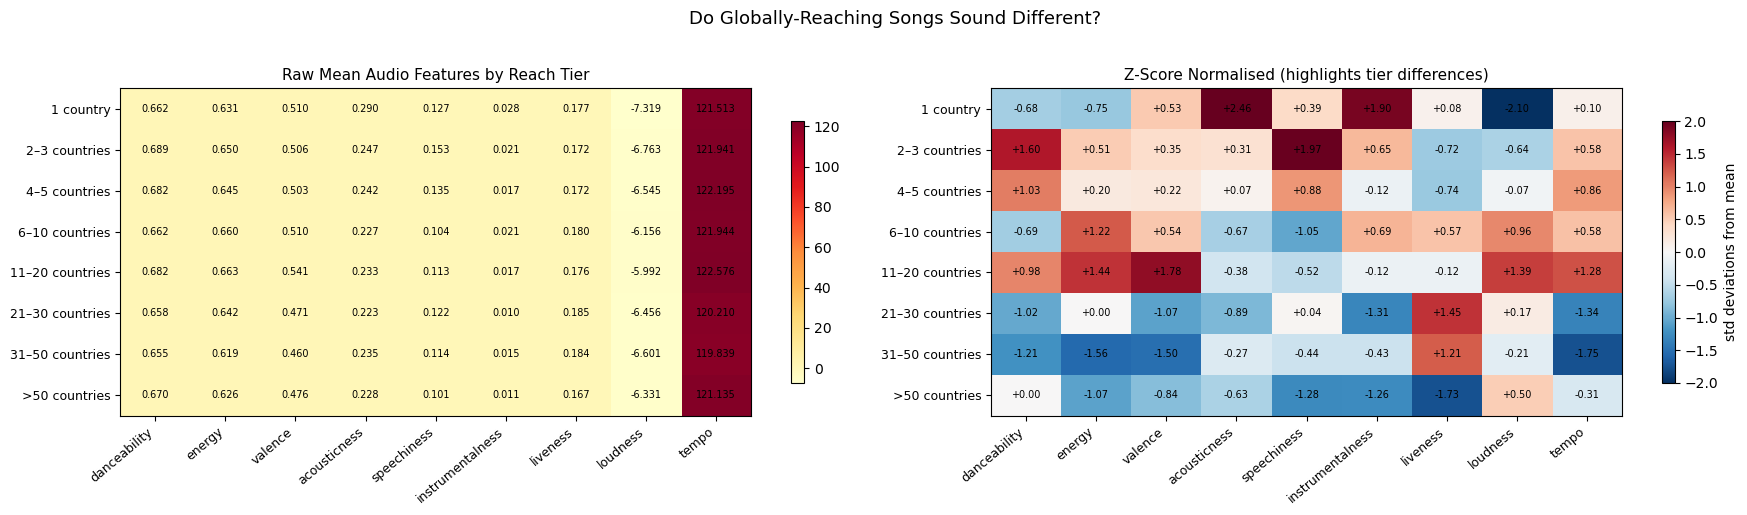

In [50]:

# ── Average Audio Features per Reach Tier ────────────────────────────────────
# Pull one row of audio features per track_id (first occurrence, deduplicated)
audio_raw = con.execute("""
    SELECT
        track_id,
        AVG(TRY_CAST(af_danceability     AS DOUBLE)) AS danceability,
        AVG(TRY_CAST(af_energy           AS DOUBLE)) AS energy,
        AVG(TRY_CAST(af_valence          AS DOUBLE)) AS valence,
        AVG(TRY_CAST(af_acousticness     AS DOUBLE)) AS acousticness,
        AVG(TRY_CAST(af_speechiness      AS DOUBLE)) AS speechiness,
        AVG(TRY_CAST(af_instrumentalness AS DOUBLE)) AS instrumentalness,
        AVG(TRY_CAST(af_liveness         AS DOUBLE)) AS liveness,
        AVG(TRY_CAST(af_loudness         AS DOUBLE)) AS loudness,
        AVG(TRY_CAST(af_tempo            AS DOUBLE)) AS tempo
    FROM spotify_full
    WHERE track_id IS NOT NULL
    GROUP BY track_id
""").df()

# Join with spread to get reach_tier
spread_audio = spread[["track_id", "reach_tier"]].merge(audio_raw, on="track_id", how="left")

audio_features_cols = [
    "danceability", "energy", "valence", "acousticness",
    "speechiness", "instrumentalness", "liveness", "loudness", "tempo"
]

tier_audio = (
    spread_audio.groupby("reach_tier", observed=True)[audio_features_cols]
    .mean()
    .round(4)
)

print("═" * 70)
print("  AVERAGE AUDIO FEATURES BY REACH TIER")
print("═" * 70)
display(tier_audio)

# ── Heatmap (z-score normalised so all features are comparable) ───────────────
from scipy.stats import zscore

tier_audio_z = tier_audio.apply(zscore, axis=0)   # normalise each feature column

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Left: raw average values heatmap
im1 = axes[0].imshow(tier_audio.values, aspect="auto", cmap="YlOrRd")
axes[0].set_xticks(range(len(audio_features_cols)))
axes[0].set_xticklabels(audio_features_cols, rotation=40, ha="right", fontsize=9)
axes[0].set_yticks(range(len(tier_audio)))
axes[0].set_yticklabels(tier_audio.index, fontsize=9)
axes[0].set_title("Raw Mean Audio Features by Reach Tier", fontsize=11)
for i in range(len(tier_audio)):
    for j in range(len(audio_features_cols)):
        axes[0].text(j, i, f"{tier_audio.values[i, j]:.3f}",
                     ha="center", va="center", fontsize=7, color="black")
plt.colorbar(im1, ax=axes[0], shrink=0.8)

# Right: z-score normalised — highlights which features distinguish tiers
im2 = axes[1].imshow(tier_audio_z.values, aspect="auto", cmap="RdBu_r", vmin=-2, vmax=2)
axes[1].set_xticks(range(len(audio_features_cols)))
axes[1].set_xticklabels(audio_features_cols, rotation=40, ha="right", fontsize=9)
axes[1].set_yticks(range(len(tier_audio_z)))
axes[1].set_yticklabels(tier_audio_z.index, fontsize=9)
axes[1].set_title("Z-Score Normalised (highlights tier differences)", fontsize=11)
for i in range(len(tier_audio_z)):
    for j in range(len(audio_features_cols)):
        axes[1].text(j, i, f"{tier_audio_z.values[i, j]:+.2f}",
                     ha="center", va="center", fontsize=7, color="black")
plt.colorbar(im2, ax=axes[1], shrink=0.8, label="std deviations from mean")

plt.suptitle("Do Globally-Reaching Songs Sound Different?", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


# Business Implications

Write something :)

Computing first chart date per track per country … (may take a moment)
  Rows (track × country × chart): 359,369
  Songs tracked : 117,876
  Median days to arrive in a new country: 12 days
  Mean   days to arrive in a new country: 102.4 days

════════════════════════════════════════════════════════════
  SPREAD WIDTH — songs by countries reached
════════════════════════════════════════════════════════════
  Median countries reached per song : 1
  Mean   countries reached per song : 3.0
  Songs reaching ≥ 30 countries     : 2,475
  Songs reaching ≥ 50 countries     : 943


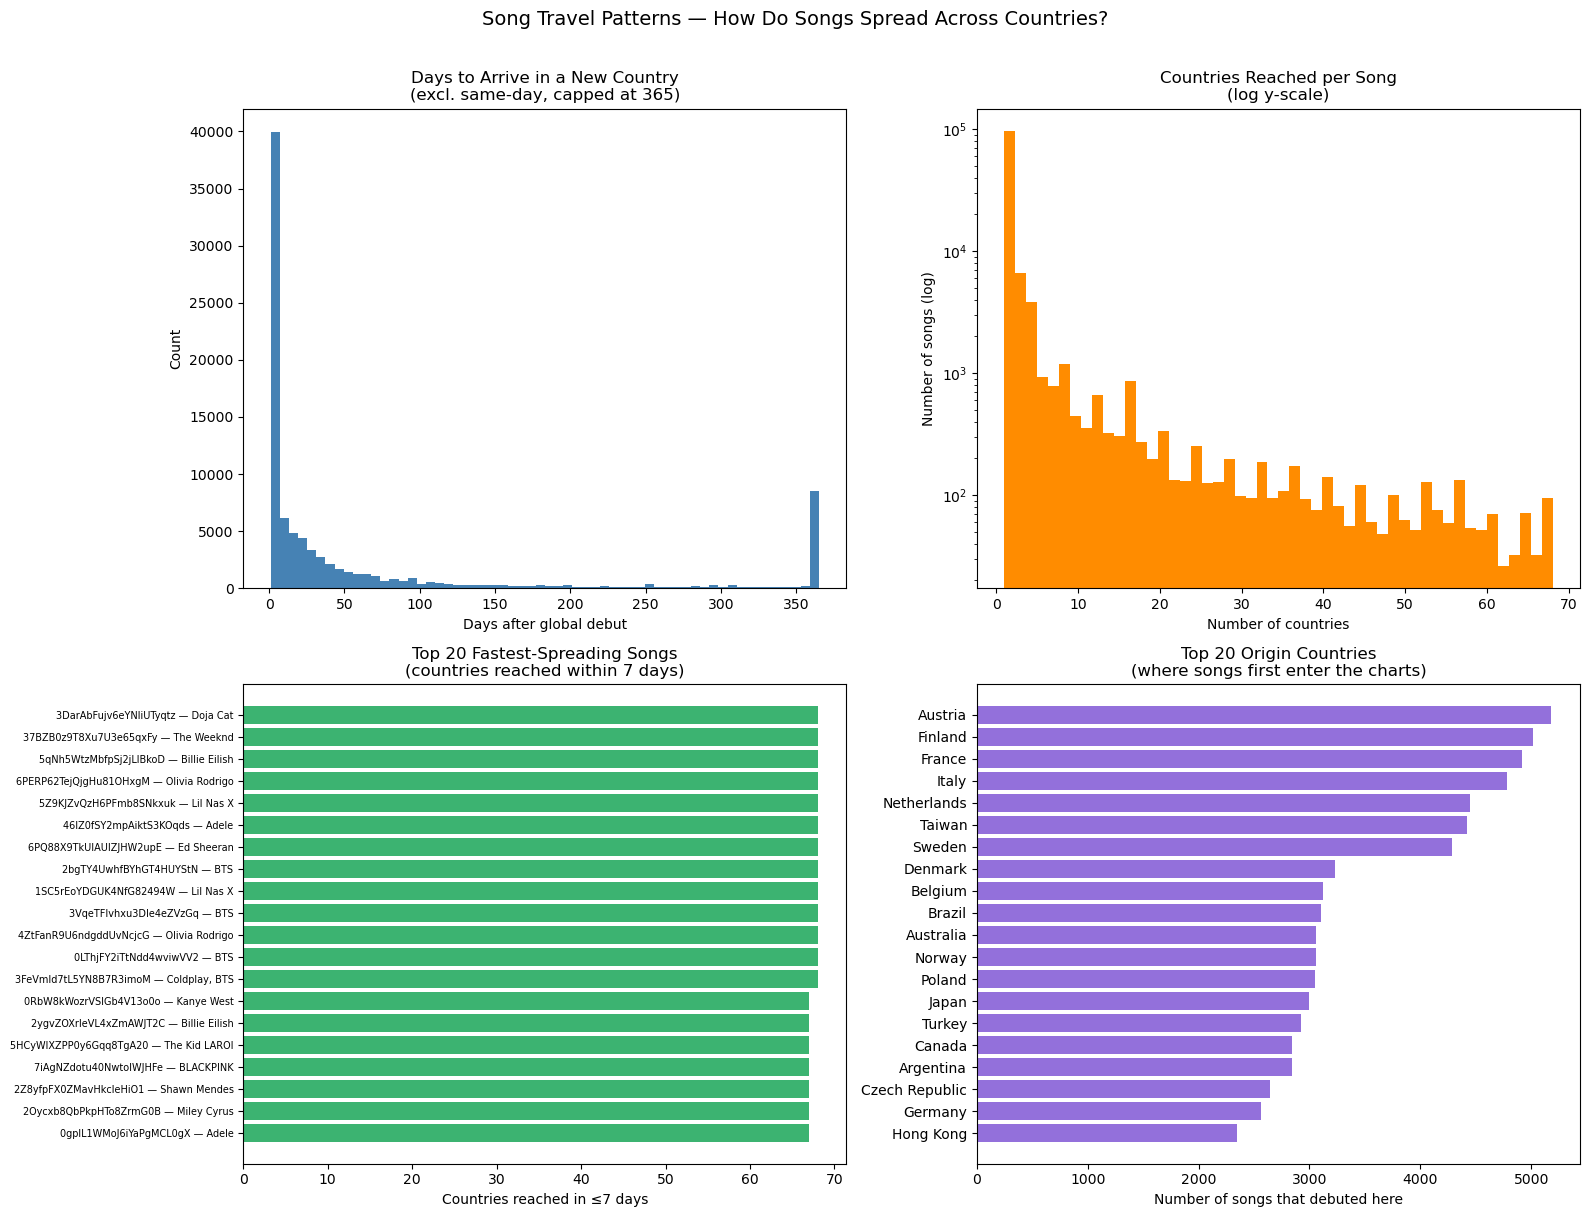


── Top 20 widest-spreading songs (most countries reached) ───


,artist,origin_country,countries_reached,days_to_50pct,max_spread_days
0,Lady Gaga,Argentina,68,0.0,250
1,BLACKPINK,Argentina,68,0.0,122
2,Doja Cat,United States,68,24.5,421
3,Ariana Grande,Argentina,68,0.0,94
4,BTS,Argentina,68,0.0,0
5,Dua Lipa,Argentina,68,0.0,311
6,Billie Eilish,Australia,68,0.0,81
7,Lil Nas X,Australia,68,0.0,42
8,Ariana Grande,Argentina,68,0.0,732
9,Doja Cat,Argentina,68,0.0,0



── Spread speed by chart type ───────────────────────────────


,chart,median_days,mean_days,n_arrivals
0,top200,12.0,102.4,90206


In [25]:
# For each (track_id, region) pair, find the first date it appeared on any chart.
# Then compute how many days after the track's global debut it reached each country.

# Step 1: First chart date per (track_id, region) 
print("Computing first chart date per track per country … (may take a moment)")

first_entry = con.execute("""
    SELECT
        track_id,
        artist,
        region,
        chart,
        MIN(CAST(date AS DATE)) AS first_chart_date
    FROM spotify_full
    WHERE track_id  IS NOT NULL
      AND streams   IS NOT NULL
      AND region    IS NOT NULL
      AND LOWER(region) != 'global'
    GROUP BY track_id, artist, region, chart
""").df()

first_entry["first_chart_date"] = pd.to_datetime(first_entry["first_chart_date"])
print(f"  Rows (track × country × chart): {len(first_entry):,}")

# Step 2: Global debut = earliest first_chart_date across all countries 
global_debut = (
    first_entry
    .groupby("track_id")["first_chart_date"]
    .min()
    .reset_index()
    .rename(columns={"first_chart_date": "global_debut"})
)

travel = first_entry.merge(global_debut, on="track_id")
travel["days_to_arrive"] = (travel["first_chart_date"] - travel["global_debut"]).dt.days

# Origin country = the country where days_to_arrive == 0
origin = (
    travel[travel["days_to_arrive"] == 0]
    .groupby("track_id")["region"]
    .agg(lambda x: x.mode().iloc[0])   # most common origin when tied
    .reset_index()
    .rename(columns={"region": "origin_country"})
)
travel = travel.merge(origin, on="track_id", how="left")

print(f"  Songs tracked : {travel['track_id'].nunique():,}")
print(f"  Median days to arrive in a new country: {travel[travel['days_to_arrive'] > 0]['days_to_arrive'].median():.0f} days")
print(f"  Mean   days to arrive in a new country: {travel[travel['days_to_arrive'] > 0]['days_to_arrive'].mean():.1f} days")

# Step 3: Spread width per song 
spread = (
    travel.groupby(["track_id", "artist", "origin_country"])
    .agg(
        countries_reached = ("region",          "nunique"),
        days_to_50pct     = ("days_to_arrive",  lambda x: x.quantile(0.5)),
        max_spread_days   = ("days_to_arrive",  "max"),
    )
    .reset_index()
)

print("\n" + "═" * 60)
print("  SPREAD WIDTH — songs by countries reached")
print("═" * 60)
print(f"  Median countries reached per song : {spread['countries_reached'].median():.0f}")
print(f"  Mean   countries reached per song : {spread['countries_reached'].mean():.1f}")
print(f"  Songs reaching ≥ 30 countries     : {(spread['countries_reached'] >= 30).sum():,}")
print(f"  Songs reaching ≥ 50 countries     : {(spread['countries_reached'] >= 50).sum():,}")

# Step 4: Visualisations 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Distribution of days_to_arrive (excluding same-day)
later = travel[travel["days_to_arrive"] > 0]["days_to_arrive"].clip(upper=365)
axes[0, 0].hist(later, bins=60, color="steelblue", edgecolor="none")
axes[0, 0].set_title("Days to Arrive in a New Country\n(excl. same-day, capped at 365)")
axes[0, 0].set_xlabel("Days after global debut")
axes[0, 0].set_ylabel("Count")

# (b) Distribution of spread width (# countries per song)
axes[0, 1].hist(spread["countries_reached"], bins=50, color="darkorange", edgecolor="none")
axes[0, 1].set_yscale("log")
axes[0, 1].set_title("Countries Reached per Song\n(log y-scale)")
axes[0, 1].set_xlabel("Number of countries")
axes[0, 1].set_ylabel("Number of songs (log)")

# (c) Top 20 fastest-spreading songs (most countries within 7 days)
fast = (
    travel[travel["days_to_arrive"] <= 7]
    .groupby(["track_id", "artist"])["region"]
    .nunique()
    .reset_index()
    .rename(columns={"region": "countries_in_7d"})
    .sort_values("countries_in_7d", ascending=False)
    .head(20)
)
axes[1, 0].barh(
    (fast["track_id"].str[:25] + " — " + fast["artist"].str[:15])[::-1],
    fast["countries_in_7d"][::-1],
    color="mediumseagreen"
)
axes[1, 0].set_title("Top 20 Fastest-Spreading Songs\n(countries reached within 7 days)")
axes[1, 0].set_xlabel("Countries reached in ≤7 days")
axes[1, 0].tick_params(axis="y", labelsize=7)

# (d) Top 20 most common origin countries (where songs chart first)
top_origins = (
    origin.merge(spread[["track_id"]], on="track_id")
    .groupby("origin_country")
    .size()
    .reset_index(name="n_songs_originated")
    .sort_values("n_songs_originated", ascending=False)
    .head(20)
)
axes[1, 1].barh(
    top_origins["origin_country"][::-1],
    top_origins["n_songs_originated"][::-1],
    color="mediumpurple"
)
axes[1, 1].set_title("Top 20 Origin Countries\n(where songs first enter the charts)")
axes[1, 1].set_xlabel("Number of songs that debuted here")

plt.suptitle("Song Travel Patterns — How Do Songs Spread Across Countries?", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Step 5: Top 20 widest-spreading songs 
print("\n── Top 20 widest-spreading songs (most countries reached) ───")
display(
    spread.sort_values("countries_reached", ascending=False)
    .head(20)[["artist", "origin_country",
               "countries_reached", "days_to_50pct", "max_spread_days"]]
    .reset_index(drop=True)
)

# Step 6: Spread speed by chart type 
print("\n── Spread speed by chart type ───────────────────────────────")
chart_speed = (
    travel[travel["days_to_arrive"] > 0]
    .groupby("chart")["days_to_arrive"]
    .agg(["median", "mean", "count"])
    .round(1)
    .rename(columns={"median": "median_days", "mean": "mean_days", "count": "n_arrivals"})
    .sort_values("median_days")
    .reset_index()
)
display(chart_speed)


════════════════════════════════════════════════════════════
  DIAGNOSING THE 365-DAY SPIKE
════════════════════════════════════════════════════════════

  Total arrivals with days_to_arrive > 0  : 90,206
  Arrivals with exactly 365 days          : 185
  Arrivals with days_to_arrive > 365      : 7,700
  Arrivals within ±5 days of 365          : 1,050

  ➜ The spike = 7,885 observations piled into one bin by .clip(upper=365)

── Arrivals by time bucket ──────────────────────────────────
  ≤ 7d           39,994  ( 44.3%)  ████████████████████████████████████████████
  8–30d          18,164  ( 20.1%)  ████████████████████
  31–90d         13,859  ( 15.4%)  ███████████████
  91–180d         5,203  (  5.8%)  █████
  181–365d        5,286  (  5.9%)  █████
  366–730d        4,167  (  4.6%)  ████
  > 730d          3,533  (  3.9%)  ███


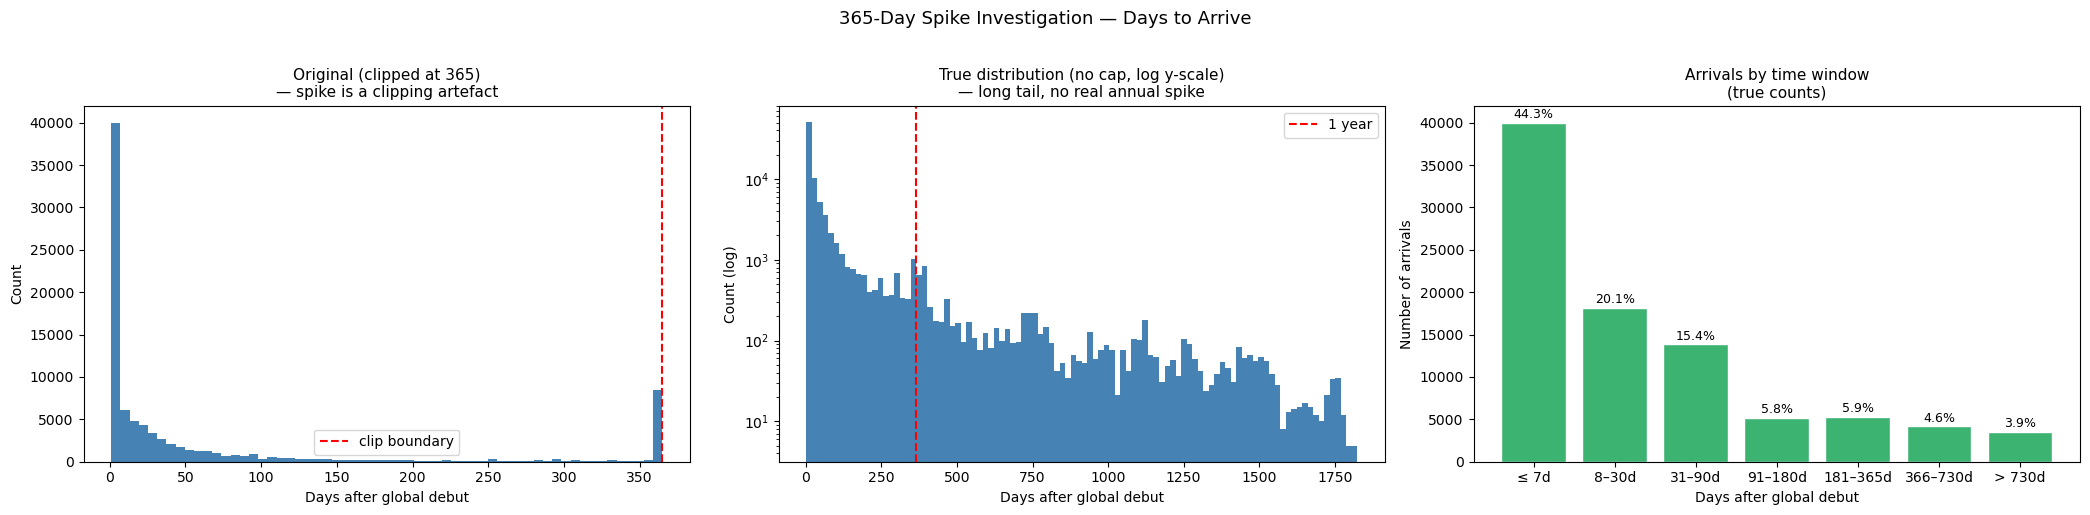

In [26]:
# ── Investigate the 365-day spike ────────────────────────────────────────────
later = travel[travel["days_to_arrive"] > 0]["days_to_arrive"]

# 1. Prove the spike is a clipping artefact
total_over_365  = (later > 365).sum()
total_at_365    = (later == 365).sum()
total_near_365  = ((later >= 360) & (later <= 370)).sum()

print("═" * 60)
print("  DIAGNOSING THE 365-DAY SPIKE")
print("═" * 60)
print(f"\n  Total arrivals with days_to_arrive > 0  : {len(later):,}")
print(f"  Arrivals with exactly 365 days          : {total_at_365:,}")
print(f"  Arrivals with days_to_arrive > 365      : {total_over_365:,}")
print(f"  Arrivals within ±5 days of 365          : {total_near_365:,}")
print(f"\n  ➜ The spike = {total_at_365 + total_over_365:,} observations piled into one bin by .clip(upper=365)")

# 2. Time-bucket breakdown of the real distribution
bins   = [0, 7, 30, 90, 180, 365, 730, float("inf")]
labels = ["≤ 7d", "8–30d", "31–90d", "91–180d", "181–365d", "366–730d", "> 730d"]
bucket = pd.cut(later, bins=bins, labels=labels, right=True)
bucket_counts = bucket.value_counts().reindex(labels)
bucket_pct    = (bucket_counts / len(later) * 100).round(1)

print("\n── Arrivals by time bucket ──────────────────────────────────")
for label, count, pct in zip(labels, bucket_counts, bucket_pct):
    bar = "█" * int(pct / 1)
    print(f"  {label:<12}  {count:>7,}  ({pct:>5.1f}%)  {bar}")

# 3. Side-by-side: original (clipped) vs corrected plots
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# (a) Original clipped histogram — reproduces the artefact
axes[0].hist(later.clip(upper=365), bins=60, color="steelblue", edgecolor="none")
axes[0].axvline(365, color="red", lw=1.5, ls="--", label="clip boundary")
axes[0].set_title("Original (clipped at 365)\n— spike is a clipping artefact", fontsize=11)
axes[0].set_xlabel("Days after global debut")
axes[0].set_ylabel("Count")
axes[0].legend()

# (b) True distribution, uncapped, log y-scale
axes[1].hist(later, bins=100, color="steelblue", edgecolor="none")
axes[1].set_yscale("log")
axes[1].axvline(365, color="red", lw=1.5, ls="--", label="1 year")
axes[1].set_title("True distribution (no cap, log y-scale)\n— long tail, no real annual spike", fontsize=11)
axes[1].set_xlabel("Days after global debut")
axes[1].set_ylabel("Count (log)")
axes[1].legend()

# (c) Bucket bar chart
axes[2].bar(labels, bucket_counts.values, color="mediumseagreen", edgecolor="white")
axes[2].set_title("Arrivals by time window\n(true counts)", fontsize=11)
axes[2].set_xlabel("Days after global debut")
axes[2].set_ylabel("Number of arrivals")
for i, (v, p) in enumerate(zip(bucket_counts.values, bucket_pct.values)):
    axes[2].text(i, v + 200, f"{p:.1f}%", ha="center", va="bottom", fontsize=9)

plt.suptitle("365-Day Spike Investigation — Days to Arrive", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

### 8.4 Song Characteristic Analysis

In [27]:
# Pull a 50 000-row random sample for plotting (avoids loading 26M rows into memory)
SAMPLE_SIZE = 1_000_000

sample_df = con.execute(f"""
    SELECT
        TRY_CAST(streams AS DOUBLE) AS streams,
        TRY_CAST(af_danceability AS DOUBLE) AS danceability,
        TRY_CAST(af_energy AS DOUBLE) AS energy,
        TRY_CAST(af_valence AS DOUBLE) AS valence,
        TRY_CAST(af_tempo AS DOUBLE) AS tempo,
        TRY_CAST(af_loudness AS DOUBLE) AS loudness,
        TRY_CAST(af_acousticness AS DOUBLE) AS acousticness,
        TRY_CAST(af_speechiness AS DOUBLE) AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness AS DOUBLE) AS liveness,
        TRY_CAST(rank AS DOUBLE) AS rank,
        TRY_CAST(popularity AS DOUBLE) AS popularity,
        chart,
        explicit,
        country_continent,
        year
    FROM spotify_full
    USING SAMPLE {SAMPLE_SIZE} ROWS
""").df()

# Add log_streams
sample_df["log_streams"] = np.log1p(sample_df["streams"].clip(lower=0))

print(f"Sample shape: {sample_df.shape}")
print("\nSample describe (numeric features):")
display(sample_df.describe())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Sample shape: (1000000, 17)

Sample describe (numeric features):


,streams,danceability,energy,valence,tempo,loudness,acousticness,speechiness,instrumentalness,liveness,rank,popularity,year,log_streams
count,7.770510e+05,988400.000000,988400.000000,988400.000000,988400.000000,988400.000000,988400.000000,988400.000000,988400.000000,988400.000000,1000000.000000,988400.000000,1000000.000000,777051.000000
mean,5.507162e+04,0.685818,0.643809,0.523461,121.146617,-6.237281,0.257619,0.109781,0.013383,0.169354,80.978389,46.639144,2019.136651,9.400119
std,2.087292e+05,0.137228,0.166326,0.222860,29.403715,2.507398,0.246020,0.099953,0.085041,0.129167,59.155943,30.823175,1.389931,1.556867
min,1.001000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2017.000000,6.909753
25%,3.549000e+03,0.601000,0.536000,0.350000,97.022000,-7.470000,0.056300,0.042700,0.000000,0.093400,29.000000,7.000000,2018.000000,8.174703
50%,9.559000e+03,0.704000,0.662000,0.523000,118.642500,-5.853000,0.177000,0.067400,0.000000,0.120000,67.000000,57.000000,2019.000000,9.165343
75%,3.530800e+04,0.785000,0.769000,0.697000,140.013000,-4.529000,0.395000,0.136000,0.000026,0.197000,131.000000,73.000000,2020.000000,10.471893
max,1.229205e+07,0.987000,1.000000,0.992000,238.431000,1.906000,0.996000,0.966000,0.990000,0.990000,200.000000,96.000000,2021.000000,16.324464


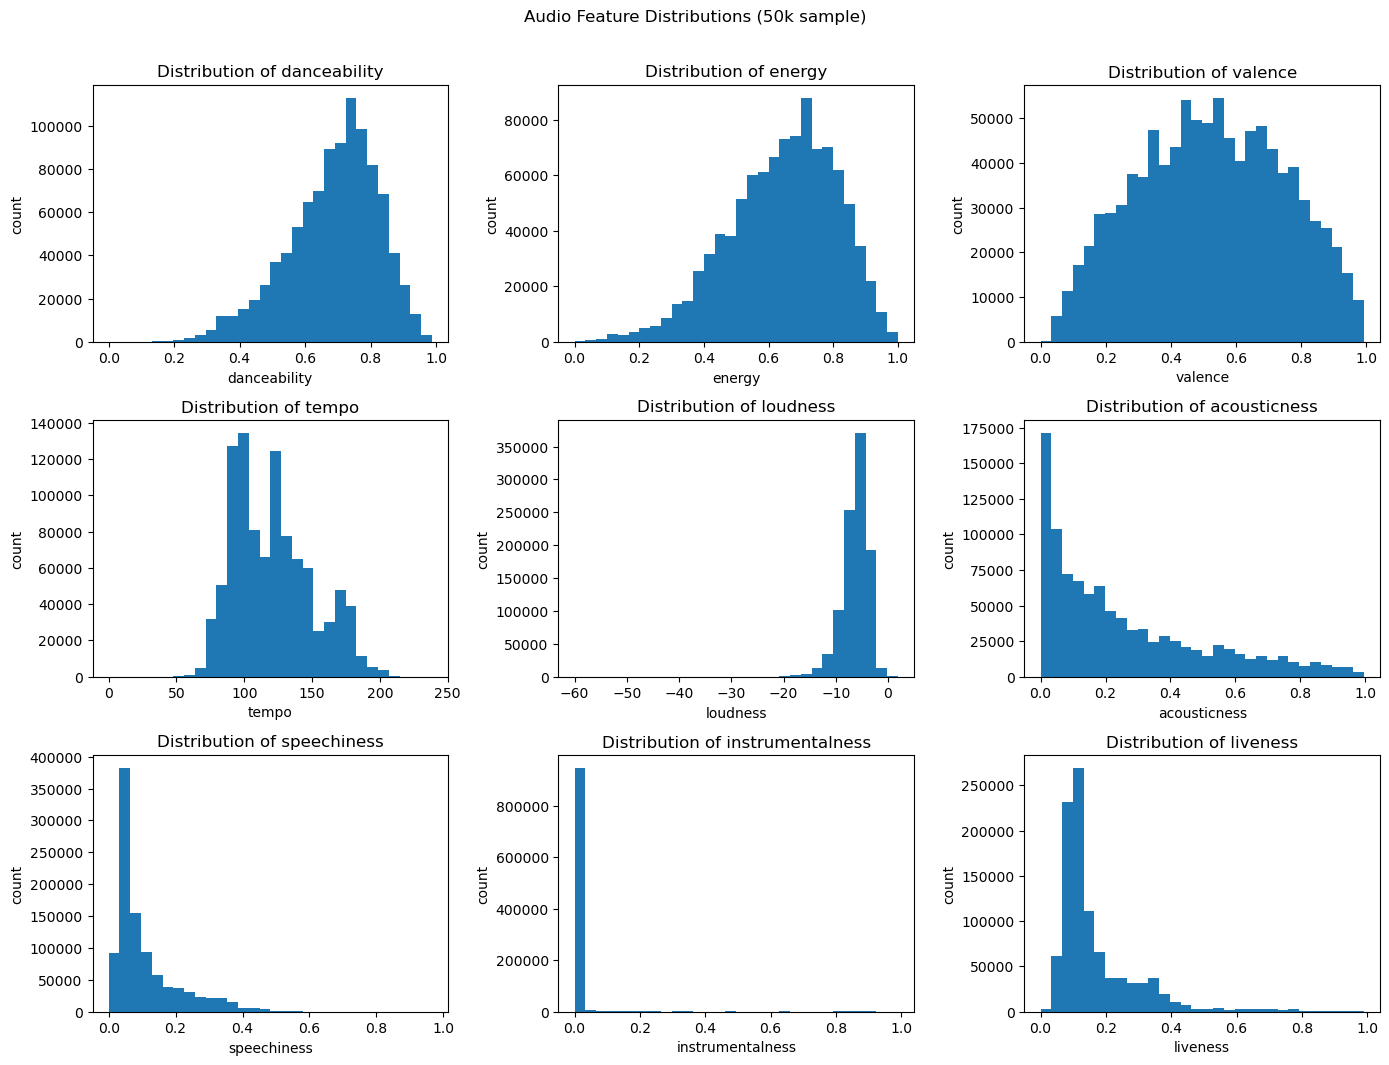

In [28]:
# Histograms of all numeric audio features 
audio_features = ["danceability", "energy", "valence", "tempo",
                   "loudness", "acousticness", "speechiness",
                   "instrumentalness", "liveness"]

n_cols = 3
n_rows = (len(audio_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 3.5))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    data = sample_df[feat].dropna()
    axes[i].hist(data, bins=30, edgecolor="none")
    axes[i].set_title(f"Distribution of {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("count")

# Hide unused axes
for j in range(len(audio_features), len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Audio Feature Distributions (50k sample)", y=1.01)
plt.tight_layout()
plt.show()


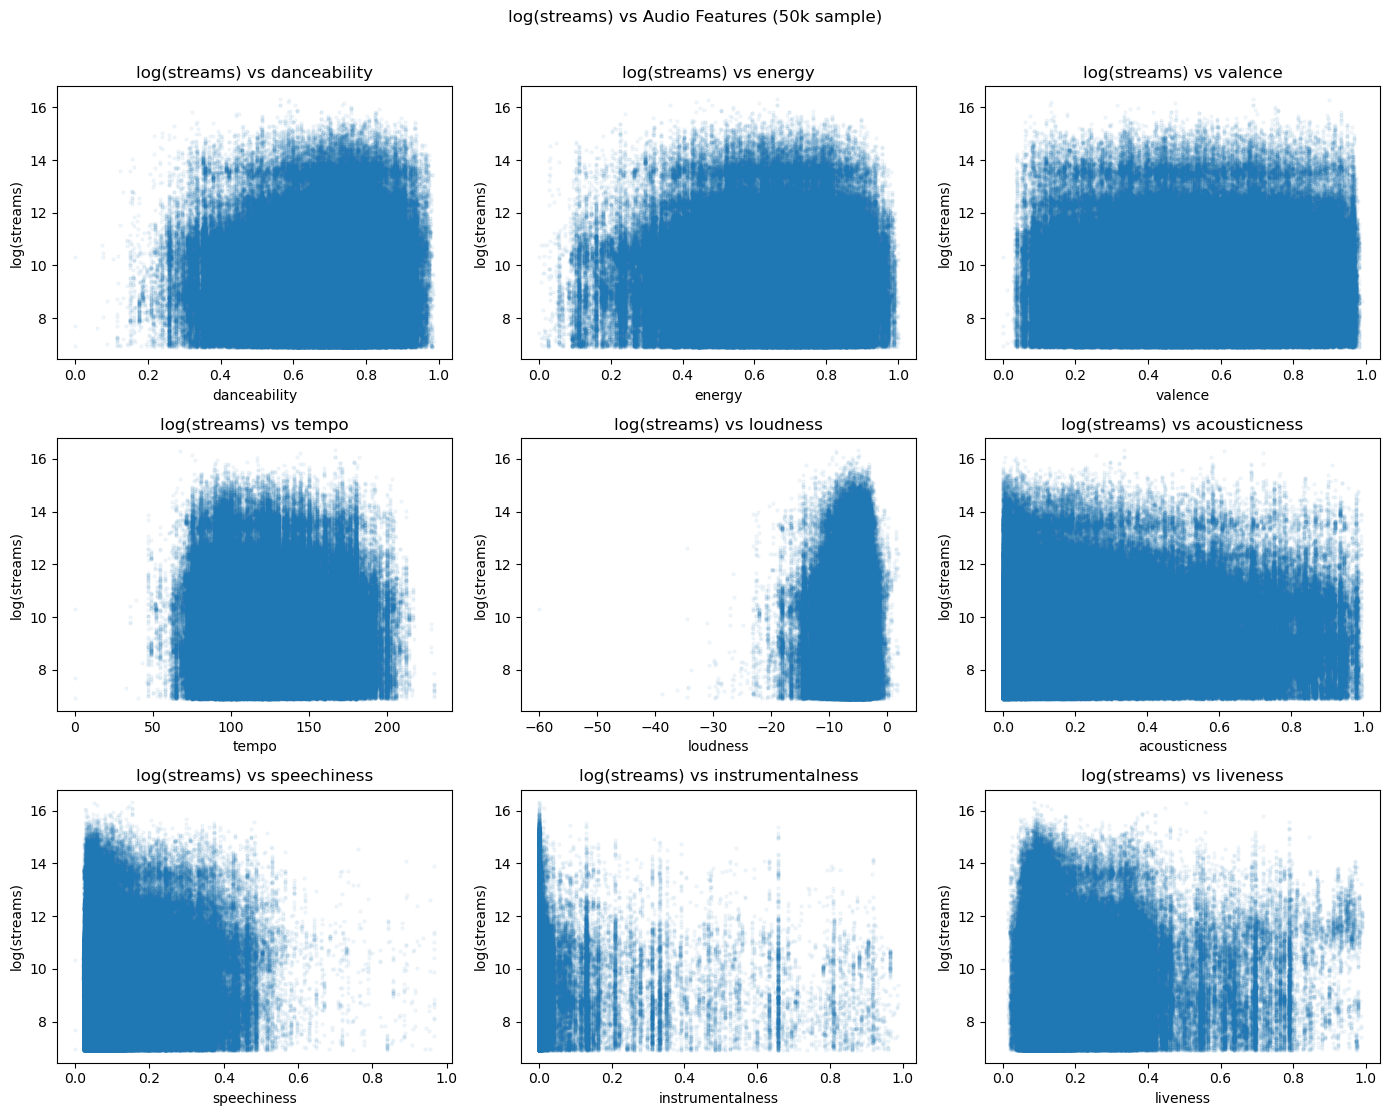

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(14, 11))
axes = axes.ravel()

for i, feat in enumerate(audio_features):
    x = sample_df[feat].dropna()
    y = sample_df.loc[x.index, "log_streams"].dropna()
    common = x.index.intersection(y.index)
    axes[i].scatter(x[common], y[common], alpha=0.05, s=5)
    axes[i].set_title(f"log(streams) vs {feat}")
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel("log(streams)")

plt.suptitle("log(streams) vs Audio Features (50k sample)", y=1.01)
plt.tight_layout()
plt.show()

### 8.5 Correlation

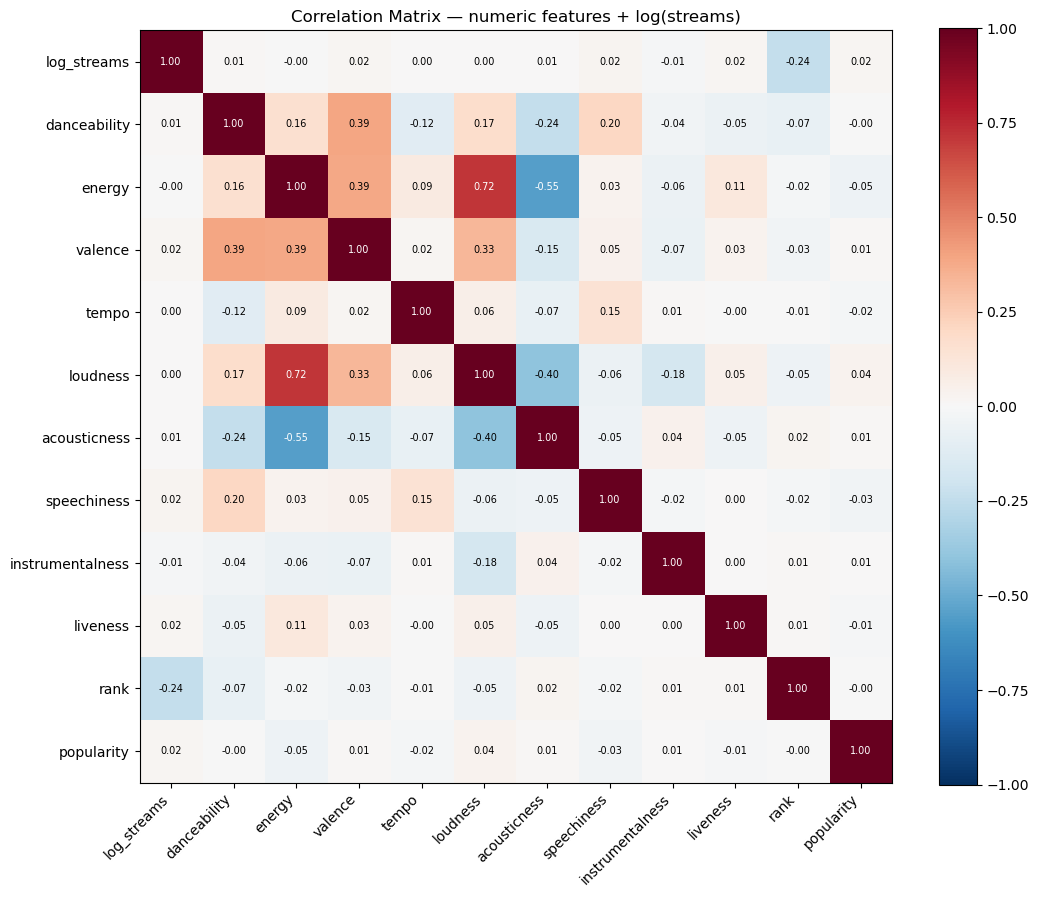


Correlations with log(streams) (sorted):
rank               -0.241911
speechiness         0.023904
liveness            0.021308
popularity          0.019770
valence             0.019693
instrumentalness   -0.014376
danceability        0.011084
acousticness        0.007158
tempo               0.004684
energy             -0.004355
loudness            0.002139


In [30]:
corr_df = con.execute("""
    SELECT
        LN(TRY_CAST(streams        AS DOUBLE)) AS log_streams,
        TRY_CAST(af_danceability   AS DOUBLE)  AS danceability,
        TRY_CAST(af_energy         AS DOUBLE)  AS energy,
        TRY_CAST(af_valence        AS DOUBLE)  AS valence,
        TRY_CAST(af_tempo          AS DOUBLE)  AS tempo,
        TRY_CAST(af_loudness       AS DOUBLE)  AS loudness,
        TRY_CAST(af_acousticness   AS DOUBLE)  AS acousticness,
        TRY_CAST(af_speechiness    AS DOUBLE)  AS speechiness,
        TRY_CAST(af_instrumentalness AS DOUBLE) AS instrumentalness,
        TRY_CAST(af_liveness       AS DOUBLE)  AS liveness,
        TRY_CAST(rank              AS DOUBLE)  AS rank,
        TRY_CAST(popularity        AS DOUBLE)  AS popularity
    FROM spotify_full
    WHERE streams IS NOT NULL
      AND TRY_CAST(streams AS DOUBLE) > 0
    USING SAMPLE 50000
""").df()

corr = corr_df.dropna().corr()

fig, ax = plt.subplots(figsize=(11, 9))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(im, ax=ax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", fontsize=7,
                color="white" if abs(corr.iloc[i, j]) > 0.5 else "black")

ax.set_title("Correlation Matrix — numeric features + log(streams)")
plt.tight_layout()
plt.show()

print("\nCorrelations with log(streams) (sorted):")
print(corr["log_streams"].drop("log_streams").sort_values(key=abs, ascending=False).to_string())


## 9. Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [31]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (749510, 14)
Train size: (562132, 13)  Test size: (187378, 13)


## 10. Split + Preprocess (without data leakage)
- Identify numeric and categorical features
- Build a `Pipeline` with `StandardScaler` for numeric and `OneHotEncoder` for categorical
- Perform a **75 / 25 train / test split** (`random_state=42`)

Because the full 26M-row dataset cannot fit into pandas memory, we use the **50k random sample**
already pulled in section 8. This gives a realistic and reproducible modelling baseline.

**Why a pipeline?**
- Prevents *data leakage* (scaler / encoder is fit only on train data during `.fit()`)
- Makes cross-validation safe and straightforward


In [32]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ── Define features and target ──
TARGET = "log_streams"

NUMERIC_FEATURES = [
    "danceability", "energy", "valence", "tempo",
    "loudness", "acousticness", "speechiness",
    "instrumentalness", "liveness", "popularity"
]
CATEGORICAL_FEATURES = ["chart", "explicit", "country_continent"]

# Drop rows where target or any feature is missing
model_df = sample_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES + [TARGET]].dropna()
print(f"Modelling sample after dropping NaNs: {model_df.shape}")

X = model_df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
y = model_df[TARGET]

# ── Build preprocessing pipeline ──
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

# ── Train / test split ──
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train size: {X_train.shape}  Test size: {X_test.shape}")


Modelling sample after dropping NaNs: (749510, 14)
Train size: (562132, 13)  Test size: (187378, 13)


## 11. Baseline: Linear Regression

We fit a standard **least-squares linear regression**
and evaluate with:

- **RMSE** (in log-streams units)
- **R²** (fraction of variance explained)

**Checkpoint (think about these before running the next cell):**
- What does RMSE mean here if our target is `log(streams)`?
- What R² would you consider "good" for streaming data?


In [33]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ── Fit linear regression pipeline ──
lr_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression()),
])

lr_pipe.fit(X_train, y_train)

# ── Predictions ──
y_train_pred = lr_pipe.predict(X_train)
y_test_pred  = lr_pipe.predict(X_test)

# ── Metrics ──
print("=== Linear Regression — Train ===")
print(f"  RMSE : {rmse(y_train, y_train_pred):.4f}")
print(f"  R²   : {r2_score(y_train, y_train_pred):.4f}")

print("\n=== Linear Regression — Test ===")
print(f"  RMSE : {rmse(y_test, y_test_pred):.4f}")
print(f"  R²   : {r2_score(y_test, y_test_pred):.4f}")

# ── Cross-validation on train set ──
cv_r2 = cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring="r2")
print(f"\n5-fold CV R²: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


=== Linear Regression — Train ===
  RMSE : 1.4203
  R²   : 0.0442

=== Linear Regression — Test ===
  RMSE : 1.4210
  R²   : 0.0450

5-fold CV R²: 0.0441 ± 0.0013


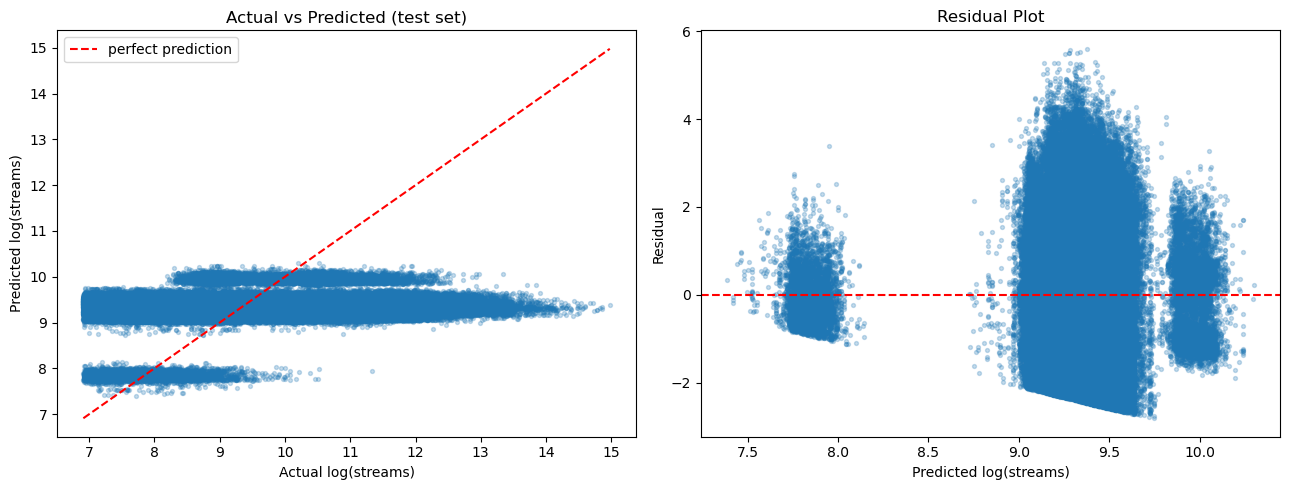

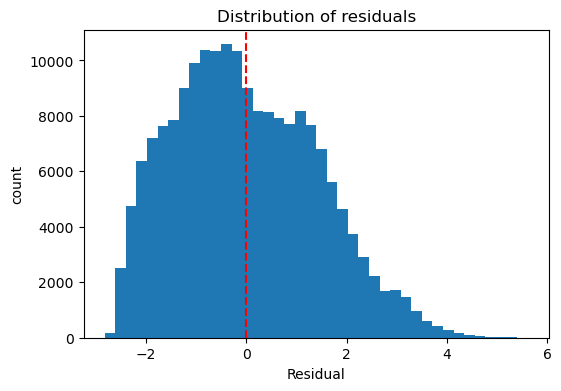

In [34]:
# ── Actual vs Predicted — diagnostic plot ──
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.25, s=8)
lo = min(y_test.min(), y_test_pred.min())
hi = max(y_test.max(), y_test_pred.max())
axes[0].plot([lo, hi], [lo, hi], "r--", lw=1.5, label="perfect prediction")
axes[0].set_xlabel("Actual log(streams)")
axes[0].set_ylabel("Predicted log(streams)")
axes[0].set_title("Actual vs Predicted (test set)")
axes[0].legend()

# Residuals
residuals = y_test.values - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.25, s=8)
axes[1].axhline(0, color="red", lw=1.5, linestyle="--")
axes[1].set_xlabel("Predicted log(streams)")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="none")
plt.axvline(0, color="red", linestyle="--")
plt.title("Distribution of residuals")
plt.xlabel("Residual")
plt.ylabel("count")
plt.show()

## 14. Coefficient Inspection

statsmodels OLS summary. We extract the linear regression coefficients
to understand which features drive the model.


Top 15 most influential features (by |coefficient|):


,feature,coefficient,abs_coefficient
14,country_continent_Oceania,2.121956,2.121956
15,country_continent_South America,1.650810,1.650810
12,country_continent_Europe,1.617289,1.617289
13,country_continent_North America,1.431677,1.431677
11,country_continent_Asia,1.310273,1.310273
10,explicit_True,0.120742,0.120742
8,liveness,0.028057,0.028057
0,danceability,-0.026802,0.026802
4,loudness,-0.024283,0.024283
7,instrumentalness,-0.021837,0.021837



Model Intercept: 7.794274435883864


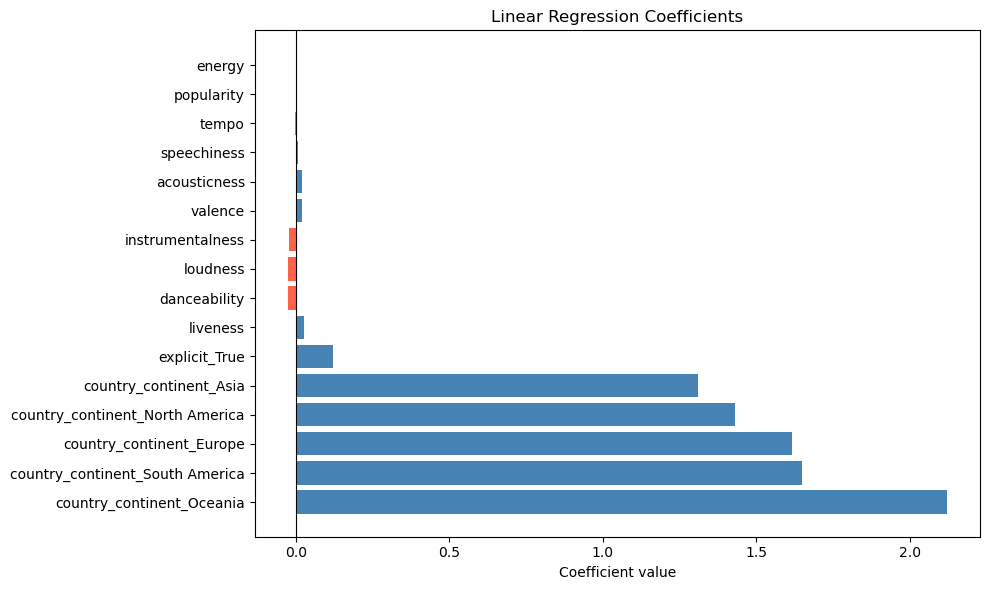

In [35]:
# Extract feature names after preprocessing
ohe_cats = lr_pipe.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(CATEGORICAL_FEATURES).tolist()
feature_names = NUMERIC_FEATURES + ohe_cats

# Create DataFrame with normal and absolute coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_pipe.named_steps["model"].coef_,
})
# Calculate the absolute value of the coefficients
coef_df["abs_coefficient"] = coef_df["coefficient"].abs()

# Sort by absolute value and display the top 15
coef_df = coef_df.sort_values("abs_coefficient", ascending=False)
print("Top 15 most influential features (by |coefficient|):")
display(coef_df.head(15))

# Extract and print the model intercept
intercept = lr_pipe.named_steps["model"].intercept_
print(f"\nModel Intercept: {intercept}")

# Bar chart of all coefficients
fig, ax = plt.subplots(figsize=(10, 6))
# Ensure chart remains sorted by influence for readability
colors = ["steelblue" if c >= 0 else "tomato" for c in coef_df["coefficient"]]
ax.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
ax.axvline(0, color="black", lw=0.8)
ax.set_title("Linear Regression Coefficients")
ax.set_xlabel("Coefficient value")
plt.tight_layout()
plt.show()

### Interpreting the linear model coefficients (what increases/decreases predictions)

**Rule:**  
- **Positive coefficient (+)** → increases the prediction  
- **Negative coefficient (−)** → decreases the prediction  
- For **dummy variables** (e.g., `country_continent_Europe`), the coefficient is the effect **relative to the omitted reference category** (the continent that has no dummy).

### If the target is `log(streams)` (as in our EDA)
Then coefficients are easiest to read as **multiplicative / % effects**:

- A coefficient **β** corresponds to multiplying streams by **exp(β)**  
- Approx. percent change: **(exp(β) − 1) × 100%**

### Which variables increase predictions?
Largest positive effects (vs. reference continent):
- `country_continent_Oceania` **(+2.059)** → exp(2.059) ≈ **7.84×** (≈ **+684%**)
- `country_continent_South America` **(+1.618)** → ≈ **5.05×** (≈ **+405%**)
- `country_continent_Europe` **(+1.600)** → ≈ **4.95×** (≈ **+395%**)
- `country_continent_North America` **(+1.482)** → ≈ **4.40×** (≈ **+340%**)
- `country_continent_Asia` **(+1.267)** → ≈ **3.55×** (≈ **+255%**)

Other positive effects:
- `explicit_True` **(+0.086)** → exp(0.086) ≈ **1.09×** (≈ **+9%**)
- Small positives: `acousticness`, `liveness`, `valence`, `tempo`, `popularity`, `energy`

### Which variables decrease predictions?
- `danceability` **(−0.027)**
- `instrumentalness` **(−0.021)**
- `loudness` **(−0.020)**

(If the target is log(streams), β = −0.027 means exp(−0.027) ≈ **0.973×** → about **−2.7%** for a +1 unit change in that feature.)

### Are effects large or small?
- **Very large:** the **continent dummies** (coefficients ~1.3–2.1) dominate the model → they change predictions by **multiples**.
- **Medium:** `explicit_True` (~0.086) → around **single-digit %** effect.
- **Small:** most audio features have |β| around **0.02–0.03** (small changes in predicted log(streams)).

 Important: comparing “importance” by |coefficient| only makes sense if features are on **similar scales** (e.g., standardized). If not standardized, coefficient size also reflects the feature’s units (tempo in BPM, popularity 0–100, etc.).

### Are signs intuitive?
- **Instrumentalness negative**: intuitive (instrumentals often stream less in mainstream charts).
- **Popularity positive**: intuitive.
- **Continent effects**: plausible (differences in market size / Spotify usage / chart mechanics), but not causal.
- **Danceability negative / loudness negative**: might be counterintuitive and can depend on **scaling**, omitted variables, or correlations among features (multicollinearity). These signs should be discussed as “associations,” not causal effects.

**Intercept:** 7.83 means the baseline prediction (when all features = 0 and the reference categories apply) is **log(streams)=7.83** (streams ≈ exp(7.83) ≈ 2,517), but this baseline may not be realistic if “0” is outside typical feature values.


## 15. Regularization: Ridge | Lasso | ElasticNet

### Why Regularization?
Real datasets often have:
- Multicollinearity (e.g. energy and loudness are correlated)
- Noise
- Many one-hot-encoded dummy features

**Ridge** adds an L2 penalty to shrink all coefficients; **Lasso** adds an L1 penalty and can zero out irrelevant features.
Both reduce overfitting and improve generalization.**ElasticNet** is a modebel which behaves like Ridge (stable) + Lasso (some selection)
,especially good when predictors are correlated and you want interpretability.

In [36]:
rows = []

ridge_alphas = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
enet_alphas  = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios    = [0.2, 0.5, 0.8]

# --- LinearRegression ---
pipe = Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
pipe.fit(X_train, y_train)
rows.append({
    "train_rmse": rmse(y_train, pipe.predict(X_train)),
    "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
    "train_r2":   r2_score(y_train, pipe.predict(X_train)),
    "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
    "model":      "LinearRegression",
    "alpha":      np.nan
})

# --- Ridge ---
for a in ridge_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=a))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Ridge",
        "alpha":      a
    })

# --- Lasso ---
for a in lasso_alphas:
    pipe = Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=a, max_iter=20000))])
    pipe.fit(X_train, y_train)
    rows.append({
        "train_rmse": rmse(y_train, pipe.predict(X_train)),
        "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
        "train_r2":   r2_score(y_train, pipe.predict(X_train)),
        "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
        "model":      "Lasso",
        "alpha":      a
    })

# --- ElasticNet (encode l1_ratio into model name so column isn't needed) ---
for a in enet_alphas:
    for r in l1_ratios:
        pipe = Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=a, l1_ratio=r, max_iter=20000))])
        pipe.fit(X_train, y_train)
        rows.append({
            "train_rmse": rmse(y_train, pipe.predict(X_train)),
            "test_rmse":  rmse(y_test,  pipe.predict(X_test)),
            "train_r2":   r2_score(y_train, pipe.predict(X_train)),
            "test_r2":    r2_score(y_test,  pipe.predict(X_test)),
            "model":      f"ElasticNet(r={r})",
            "alpha":      a
        })

results_df = pd.DataFrame(rows)
results_df[["train_rmse","test_rmse","train_r2","test_r2"]] = results_df[["train_rmse","test_rmse","train_r2","test_r2"]].round(6)
results_df["alpha"] = results_df["alpha"].round(6)

results_df = results_df.sort_values(["test_rmse", "test_r2"], ascending=[True, False]).reset_index(drop=True)
display(results_df)

,train_rmse,test_rmse,train_r2,test_r2,model,alpha
0,1.420283,1.421008,0.044190,0.044978,LinearRegression,NaN
1,1.420283,1.421008,0.044190,0.044978,Ridge,0.0010
2,1.420283,1.421008,0.044190,0.044978,Ridge,0.0100
3,1.420283,1.421008,0.044190,0.044978,Ridge,0.1000
4,1.420283,1.421008,0.044190,0.044978,Ridge,1.0000
5,1.420283,1.421009,0.044190,0.044977,Ridge,10.0000
6,1.420287,1.421014,0.044185,0.044969,Lasso,0.0001
7,1.420312,1.421045,0.044151,0.044929,Ridge,100.0000
8,1.420666,1.421422,0.043675,0.044421,Lasso,0.0010
9,1.420726,1.421484,0.043594,0.044338,ElasticNet(r=0.8),0.0010


Best config per model family (by test RMSE):


,model,alpha,test_rmse,test_r2
0,ElasticNet(r=0.2),0.0010,1.421667,0.044092
1,ElasticNet(r=0.5),0.0010,1.421576,0.044214
2,ElasticNet(r=0.8),0.0010,1.421484,0.044338
3,Lasso,0.0001,1.421014,0.044969
4,LinearRegression,NaN,1.421008,0.044978
5,Ridge,0.0010,1.421008,0.044978


ElasticNet(r=0.2)  (alpha=0.001)
  CV RMSE per fold : [1.419  1.4231 1.4203 1.4198 1.4225]
  Mean CV RMSE     : 1.4209
  Std  CV RMSE     : 0.0016

ElasticNet(r=0.5)  (alpha=0.001)
  CV RMSE per fold : [1.4189 1.423  1.4202 1.4197 1.4224]
  Mean CV RMSE     : 1.4209
  Std  CV RMSE     : 0.0016

ElasticNet(r=0.8)  (alpha=0.001)
  CV RMSE per fold : [1.4188 1.423  1.4201 1.4197 1.4223]
  Mean CV RMSE     : 1.4208
  Std  CV RMSE     : 0.0016

Lasso  (alpha=0.0001)
  CV RMSE per fold : [1.4183 1.4226 1.4196 1.4192 1.422 ]
  Mean CV RMSE     : 1.4203
  Std  CV RMSE     : 0.0017

LinearRegression  (alpha=nan)
  CV RMSE per fold : [1.4183 1.4226 1.4196 1.4192 1.422 ]
  Mean CV RMSE     : 1.4203
  Std  CV RMSE     : 0.0017

Ridge  (alpha=0.001)
  CV RMSE per fold : [1.4183 1.4226 1.4196 1.4192 1.422 ]
  Mean CV RMSE     : 1.4203
  Std  CV RMSE     : 0.0017

CV summary (sorted by Mean CV RMSE):


,model,alpha,cv_rmse_mean,cv_rmse_std,test_rmse,gap (cv - test)
0,Lasso,0.0001,1.4203,0.0017,1.421014,-0.0007
1,LinearRegression,NaN,1.4203,0.0017,1.421008,-0.0007
2,Ridge,0.0010,1.4203,0.0017,1.421008,-0.0007
3,ElasticNet(r=0.8),0.0010,1.4208,0.0016,1.421484,-0.0007
4,ElasticNet(r=0.2),0.0010,1.4209,0.0016,1.421667,-0.0008
5,ElasticNet(r=0.5),0.0010,1.4209,0.0016,1.421576,-0.0007


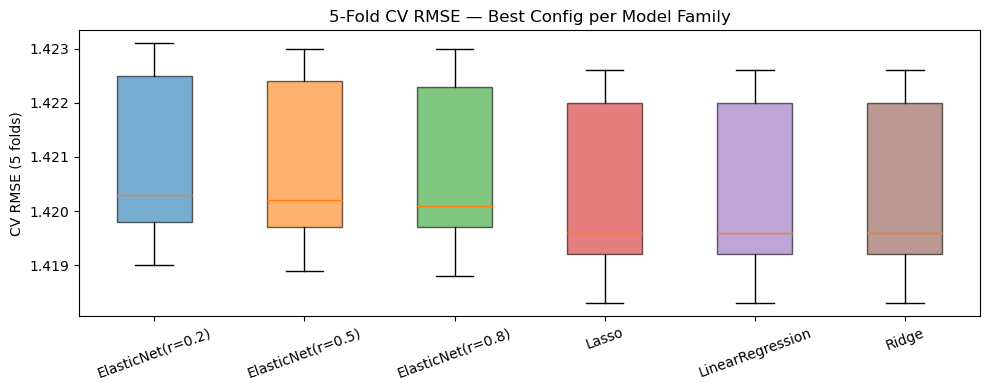

In [37]:
# ── Pick the best alpha per model family from the grid search ─────────────────
# We take the row with the lowest test_rmse for each model family.
# ElasticNet variants are grouped by their full name (which encodes l1_ratio).

best_configs = (
    results_df
    .loc[results_df.groupby("model")["test_rmse"].idxmin()]
    .reset_index(drop=True)
)
print("Best config per model family (by test RMSE):")
display(best_configs[["model", "alpha", "test_rmse", "test_r2"]])

# Build the winning pipelines
def build_pipe(model_name: str, alpha: float) -> Pipeline:
    if model_name == "LinearRegression":
        return Pipeline([("preprocess", preprocess), ("model", LinearRegression())])
    elif model_name == "Ridge":
        return Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=alpha))])
    elif model_name == "Lasso":
        return Pipeline([("preprocess", preprocess), ("model", Lasso(alpha=alpha, max_iter=20000))])
    elif model_name.startswith("ElasticNet"):
        # parse l1_ratio from the encoded name, e.g. "ElasticNet(r=0.5)"
        l1 = float(model_name.split("r=")[1].rstrip(")"))
        return Pipeline([("preprocess", preprocess),
                         ("model", ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=20000))])
    else:
        raise ValueError(f"Unknown model: {model_name}")

# 5-fold CV on the BEST config per family
# cross_val_score returns *negative* RMSE → multiply by -1

cv_rows = []

for _, row in best_configs.iterrows():
    name  = row["model"]
    alpha = row["alpha"]
    pipe  = build_pipe(name, alpha)

    neg_rmse_scores = cross_val_score(
        pipe, X_train, y_train,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    rmse_scores = -neg_rmse_scores

    cv_rows.append({
        "model":          name,
        "alpha":          alpha,
        "cv_rmse_mean":   round(rmse_scores.mean(), 4),
        "cv_rmse_std":    round(rmse_scores.std(),  4),
        "fold_scores":    rmse_scores.round(4).tolist(),
        "test_rmse":      row["test_rmse"],   # from grid search — for comparison
    })

    print(f"{name}  (alpha={alpha})")
    print(f"  CV RMSE per fold : {rmse_scores.round(4)}")
    print(f"  Mean CV RMSE     : {rmse_scores.mean():.4f}")
    print(f"  Std  CV RMSE     : {rmse_scores.std():.4f}")
    print()

# ── Summary table ─────────────────────────────────────────────────────────────
cv_summary = pd.DataFrame(cv_rows).sort_values("cv_rmse_mean").reset_index(drop=True)
cv_summary["gap (cv - test)"] = (cv_summary["cv_rmse_mean"] - cv_summary["test_rmse"]).round(4)
print("CV summary (sorted by Mean CV RMSE):")
display(cv_summary[["model", "alpha", "cv_rmse_mean", "cv_rmse_std", "test_rmse", "gap (cv - test)"]])

# ── Boxplot: CV RMSE spread per winning model ─────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
labels = [r["model"] for r in cv_rows]
data   = [r["fold_scores"] for r in cv_rows]
bp = ax.boxplot(data, labels=labels, patch_artist=True)

colors = plt.cm.tab10.colors
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel("CV RMSE (5 folds)")
ax.set_title("5-Fold CV RMSE — Best Config per Model Family")
ax.tick_params(axis="x", rotation=20)
plt.tight_layout()
plt.show()

## 16. Gradient Descent — From Scratch



This section is for *conceptual reinforcement*. We re-implement linear regression
using **batch gradient descent** on the same preprocessed design matrix, then compare
results to sklearn's closed-form solution.

**How it works:**
1. Start with `θ = 0` (all-zero coefficients)
2. Compute predictions: `ŷ = X · θ`
3. Compute gradient of MSE: `∇ = (2/m) · Xᵀ(ŷ − y)`
4. Update: `θ ← θ − lr · ∇`
5. Repeat for `n_iter` steps

**Checkpoint (think about these before running):**
- What happens if the learning rate `lr` is too high? Too low?
- How do we know we've converged?
- Why must features be standardised before gradient descent?

## Why Gradient Descent Matters
This section shows *how* models learn under the hood:
- Start with random / zero coefficients
- Iteratively reduce the training error
- Converge toward the optimal solution

Focus on the concept — not every line of maths.


In [38]:
# ── Step 1: Extract the preprocessed design matrix ──────────────────────────
# Reuse the already-fit preprocessor from lr_pipe (section 13)
# Refit here so this cell works even if run out of order
preprocess_fit = preprocess.fit(X_train)

X_train_gd = preprocess_fit.transform(X_train)
X_test_gd  = preprocess_fit.transform(X_test)

# Convert to dense if sparse
X_train_gd = X_train_gd.toarray() if hasattr(X_train_gd, "toarray") else X_train_gd
X_test_gd  = X_test_gd.toarray()  if hasattr(X_test_gd,  "toarray") else X_test_gd

# ── Step 2: Prepend intercept column (column of 1s) ──────────────────────────
X_train_gd = np.c_[np.ones(X_train_gd.shape[0]), X_train_gd]
X_test_gd  = np.c_[np.ones(X_test_gd.shape[0]),  X_test_gd]

print(f"X_train_gd shape: {X_train_gd.shape}  (includes intercept column)")
print(f"X_test_gd  shape: {X_test_gd.shape}")


X_train_gd shape: (562132, 17)  (includes intercept column)
X_test_gd  shape: (187378, 17)


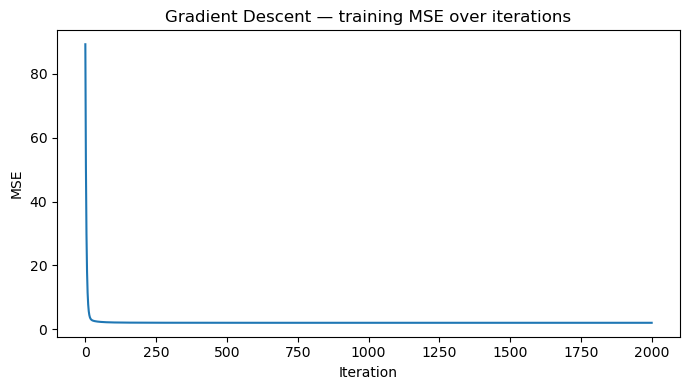

In [39]:
# ── Step 3: Gradient Descent implementation ──────────────────────────────────
def gradient_descent(X, y, lr=0.05, n_iter=2000):
    """Batch gradient descent for linear regression (MSE loss).

    Parameters
    ----------
    X      : (m, n+1) design matrix with intercept column prepended
    y      : (m,) target vector
    lr     : learning rate
    n_iter : number of gradient steps

    Returns
    -------
    theta   : (n+1,) learned coefficient vector
    history : (n_iter,) MSE at each iteration
    """
    theta = np.zeros(X.shape[1])  # initialise all weights at 0
    m = X.shape[0]
    history = []
    for _ in range(n_iter):
        y_pred = X @ theta                          # forward pass
        grad   = (2 / m) * (X.T @ (y_pred - y))    # gradient of MSE
        theta -= lr * grad                          # weight update
        history.append(mean_squared_error(y, y_pred))
    return theta, np.array(history)


theta_gd, mse_hist = gradient_descent(
    X_train_gd, y_train.values, lr=0.05, n_iter=2000
)

# ── Step 4: Plot training MSE convergence ────────────────────────────────────
plt.figure(figsize=(7, 4))
plt.plot(mse_hist, lw=1.5)
plt.title("Gradient Descent — training MSE over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()


Model                              RMSE       R²
---------------------------------------------
sklearn LinearRegression         1.4210   0.0450
Gradient Descent (lr=0.05, 2000 iters)   1.4210   0.0449

Both should be very close — gradient descent converges to the same minimum.
If they differ, try increasing n_iter or decreasing lr.


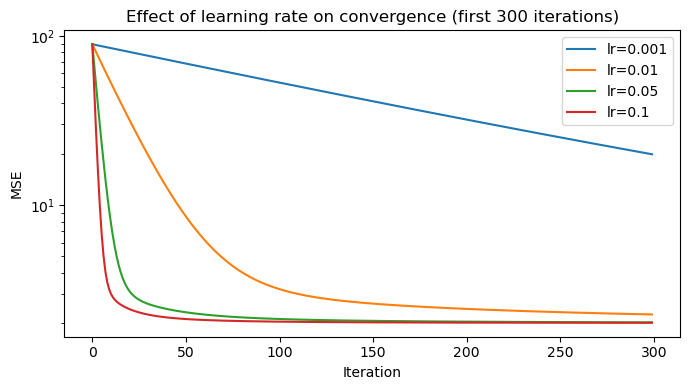

In [40]:
# ── Step 5: Evaluate on test set and compare to sklearn's closed-form ────────
y_test_pred_gd = X_test_gd @ theta_gd

rmse_gd = rmse(y_test, y_test_pred_gd)
r2_gd   = float(r2_score(y_test, y_test_pred_gd))

# Retrieve sklearn closed-form results from section 13
rmse_lr = rmse(y_test, y_test_pred)
r2_lr   = float(r2_score(y_test, y_test_pred))

print("=" * 45)
print(f"{'Model':<30} {'RMSE':>8} {'R²':>8}")
print("-" * 45)
print(f"{'sklearn LinearRegression':<30} {rmse_lr:>8.4f} {r2_lr:>8.4f}")
print(f"{'Gradient Descent (lr=0.05, 2000 iters)':<30} {rmse_gd:>8.4f} {r2_gd:>8.4f}")
print("=" * 45)
print("\nBoth should be very close — gradient descent converges to the same minimum.")
print("If they differ, try increasing n_iter or decreasing lr.")

# sensitivity to learning rate ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(7, 4))
for lr_val in [0.001, 0.01, 0.05, 0.1]:
    _, hist = gradient_descent(X_train_gd, y_train.values, lr=lr_val, n_iter=300)
    ax.plot(hist, label=f"lr={lr_val}")

ax.set_title("Effect of learning rate on convergence (first 300 iterations)")
ax.set_xlabel("Iteration")
ax.set_ylabel("MSE")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()
